In [1]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from scipy.stats import binom
from sklearn.pipeline import Pipeline
import pandas as pd
import os
from scipy import stats
import numpy as np
import glob
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import (BSplines, CubicSplines,
                                          CyclicCubicSplines)
from pygam import LinearGAM, s,f,te
from sklearn.metrics import PredictionErrorDisplay

from pygam.datasets import mcycle
from sklearn.metrics import mean_squared_error
from pickle import dump, load
import math
import pickle
import sys
import seaborn as sns
import sys
from pathlib import Path
sys.path.append('/home/scarlett/github/Ipy_notebook')  
#from Python.ROC_noLAMBDA import ROC_comparison_fix3_beta, ROC_comparison_fix3_sigma, ROC_comparison_fix3_noLambda, ROC_comparison_fix3_Lambda, get_ROC_AUC
from Python.quickBeast import get_data,get_filename, calculate_AUC_qb, Calculate_power_type1error_for_posterior,Calculate_power_type1error_pval,get_qb_p_values
from Python.functions import plot_3_hist,get_success_sample,clean_data,plot_posterior_mass_support_alt,plot_lambda,table_by_hets,table_totalcount
from Python.power import predict_lambda_from_realdata,Calculate_cutoff
from Python.ROC_common import calculate_posterior_value
from Python.read_data import read_one_pickle, get_NS_p_values
from BEASTIE import predict_lambda_GAM
from math import log,log2
import fnmatch
from prettytable import PrettyTable
import statistics
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, skewnorm, probplot

### QuickBEAST

In [2]:
file_a="/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/NA12878_real_alignBiasafterFilter.phasedByshapeit2.cleaned.tsv"
file_b="/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/quickBEASTIE_input"
untransformed = pd.read_csv('/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/NA12878_real_alignBiasafterFilter.phasedByshapeit2.cleaned.forlambda.tsv', sep='\t')
untransformed.head()

,geneID,median.altRatio,number.of.hets,total.patCount,total.matCount,totalCount
0,ENSG00000000460.12,1.000000,2,0,4,4
1,ENSG00000001036.9,0.518182,5,527,594,1121
2,ENSG00000001084.6,0.428571,3,7,9,16
3,ENSG00000001460.13,0.400000,1,3,2,5
4,ENSG00000001461.12,0.476923,1,34,31,65


In [3]:
def convert_to_file_b_format(gene_id, site_data):
    site_lines = []
    for idx, (mat_count, pat_count) in enumerate(site_data, start=1):
        site_line = "(site {} (mat {}) (pat {}) (phaseCorrect 1))".format(idx, mat_count, pat_count)
        site_lines.append(site_line)

    output = f"(gene {gene_id} (theta 1.0) {' '.join(site_lines)})"
    return output
    
    gene_block = (
        "(gene {}\n"
        "\t(theta 1.0)\n"
        "{}\n"
        "))"
    ).format(gene_id, "\n".join(site_lines))
    return gene_block

def read_file_a(file_path):
    gene_data = {}
    with open(file_path, 'r') as file:
        next(file)  # Skip header line
        for line in file:
            parts = line.strip().split('\t')
            gene_id = parts[5]
            ref_count = int(parts[7])
            alt_count = int(parts[8])
            if gene_id not in gene_data:
                gene_data[gene_id] = []
            gene_data[gene_id].append((alt_count, ref_count))  # Swap alt_count and ref_count
    return gene_data

In [4]:
gene_data = read_file_a(file_a)

file_b_blocks = []
for gene_id, site_data in gene_data.items():
    file_b_blocks.append(convert_to_file_b_format(gene_id, site_data))


file_b_content = '\n'.join(file_b_blocks)

with open(file_b, 'w') as file:
    file.write(file_b_content)

In [5]:
gene_data

{'ENSG00000187583.6': [(1, 2), (3, 1)],
 'ENSG00000188290.6': [(4, 1)],
 'ENSG00000187608.5': [(1664, 1548)],
 'ENSG00000188157.9': [(63, 66),
  (98, 104),
  (29, 48),
  (49, 68),
  (42, 64),
  (23, 44),
  (74, 80),
  (115, 141),
  (157, 194)],
 'ENSG00000237330.2': [(1, 0), (2, 0)],
 'ENSG00000131591.13': [(16, 32),
  (37, 39),
  (15, 9),
  (15, 15),
  (15, 16),
  (8, 4)],
 'ENSG00000127054.14': [(47, 32), (17, 10)],
 'ENSG00000162576.12': [(1, 2)],
 'ENSG00000242485.1': [(303, 300)],
 'ENSG00000235098.4': [(1, 0)],
 'ENSG00000160075.10': [(1, 0), (54, 62)],
 'ENSG00000228594.1': [(2, 5)],
 'ENSG00000197530.8': [(0, 1), (3, 6), (8, 12), (11, 5), (18, 7), (1, 1)],
 'ENSG00000008130.11': [(69, 65), (24, 17)],
 'ENSG00000078369.13': [(2, 4)],
 'ENSG00000157933.9': [(9, 11), (5, 11)],
 'ENSG00000116151.9': [(1, 5), (2, 4)],
 'ENSG00000157916.14': [(22, 15), (21, 27), (21, 35), (46, 80)],
 'ENSG00000157911.5': [(29, 24)],
 'ENSG00000149527.13': [(1, 1), (2, 11)],
 'ENSG00000157881.9': [(52

In [6]:
file_a="/data2/QuickBEAST/g-1000_h-9_d-90_t-1.txt"
file_b="/data2/QuickBEAST/qb_g-1000_h-9_d-90_t-1.txt"

In [7]:
def convert_format(file_a, file_b):
    with open(file_a, 'r') as fa, open(file_b, 'w') as fb:
        for line in fa.readlines():
            parts = line.strip().split("\t")
            gene_id = parts[0]
            hets = int(parts[1])
            data = parts[2:2+(2*hets)]
            
            fb.write(f'(gene {gene_id} (theta 1.0) ')
            
            for i in range(hets):
                mat = data[i*2]
                pat = data[(i*2)+1]
                fb.write(f'(site {i+1} (mat {mat}) (pat {pat}) (phaseCorrect 1)) ')
                
            fb.write(")\n")

# usage
convert_format(file_a, file_b)

### Reading the QuickBEAST output

In [9]:
df=pd.read_csv("/data2/QuickBEAST/out2.txt",delimiter="\t",header=None)
df.columns=['geneID','qb_posterior','qb_lambda']
df.head()

,geneID,qb_posterior,qb_lambda
0,ENSG00000090432,0.093582,0.047
1,ENSG00000189410,0.451752,0.063
2,ENSG00000117298,0.233373,0.089
3,ENSG00000162551,0.884309,0.087
4,ENSG00000076864,0.473746,0.060


In [10]:
df_sametype1=pd.read_csv("/data2/QuickBEAST/out_changetype1.txt",delimiter="\t",header=None)
df_sametype1.columns=['geneID','qb_posterior','qb_lambda']
df_sametype1['converted_qB_lambda_right'] = (0.5 + df_sametype1['qb_lambda']) / (1 - (0.5 + df_sametype1['qb_lambda']))
df_sametype1['converted_qB_lambda_left'] = (0.5 - df_sametype1['qb_lambda']) / (1 - (0.5 - df_sametype1['qb_lambda']))
df_sametype1['converted_qB_lambda'] = df_sametype1.apply(lambda row: max(row['converted_qB_lambda_left'], row['converted_qB_lambda_right']), axis=1)
df_sametype1.head()

,geneID,qb_posterior,qb_lambda,converted_qB_lambda_right,converted_qB_lambda_left,converted_qB_lambda
0,ENSG00000142632,0.493863,0.059,1.267574,0.788909,1.267574
1,ENSG00000132881,0.493863,0.059,1.267574,0.788909,1.267574
2,ENSG00000187583,0.262682,0.089,1.433090,0.697793,1.433090
3,ENSG00000188290,0.411539,0.074,1.347418,0.742160,1.347418
4,ENSG00000142733,0.113877,0.149,1.849003,0.540832,1.849003


In [11]:
len(df)

7636

In [12]:
GAM=pd.read_csv("/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3/NA12878_ASE_all.tsv",delimiter="\t",header=0)
GAM.head()

,Unnamed: 0,geneID,median.altRatio,number.of.hets,total.patCount,total.matCount,totalCount,gam_lambda,median_abs_deviation,posterior_median,...,Pseudo_pval,MajorSite_pval,beta_1_1_pval,beta_10_10_pval,beta_20_20_pval,beta_50_50_pval,beta_100_100_pval,beastie_ASE_gam,NS_ASE,MS_ASE
0,0,ENSG00000000460.12,1.000,2,0,4,4,1.876438,0.610,1.446,...,0.062500,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
1,1,ENSG00000001036.9,0.518,5,527,594,1121,1.345172,0.074,1.116,...,0.000767,0.003042,0.939394,0.790397,0.707686,0.561734,0.429594,0,0,0
2,2,ENSG00000001084.6,0.429,3,7,9,16,2.761880,0.366,1.101,...,0.401810,1.000000,0.823529,0.580436,0.528881,0.488004,0.472000,0,0,0
3,3,ENSG00000001460.13,0.400,1,3,2,5,1.987493,0.393,0.930,...,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0
4,4,ENSG00000001461.12,0.477,1,34,31,65,2.633816,0.179,0.922,...,0.402159,0.804317,0.969697,0.905421,0.879108,0.847346,0.829731,0,0,0


In [13]:
GAM=pd.read_csv("/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3/NA12878_ASE_all.tsv",delimiter="\t",header=0)
GAM=GAM[["geneID","number.of.hets","log2_posterior_median","posterior_median","gam_lambda","posterior_mass_support_ALT_gam","NaiveSum_pval"]]
GAM['geneID'] = GAM['geneID'].replace('\..*', '', regex=True)
GAM['converted_gam_lambda']=-0.5+GAM['gam_lambda']/(GAM['gam_lambda']+1)
GAM.head()

,geneID,number.of.hets,log2_posterior_median,posterior_median,gam_lambda,posterior_mass_support_ALT_gam,NaiveSum_pval,converted_gam_lambda
0,ENSG00000000460,2,0.531698,1.446,1.876438,0.268,0.125000,0.152348
1,ENSG00000001036,5,0.158143,1.116,1.345172,0.000,0.048647,0.073592
2,ENSG00000001084,3,0.139430,1.101,2.761880,0.003,0.803619,0.234175
3,ENSG00000001460,1,-0.105265,0.930,1.987493,0.100,1.000000,0.165271
4,ENSG00000001461,1,-0.117060,0.922,2.633816,0.000,0.804317,0.224807


In [14]:
len(GAM)

7636

In [15]:
overlapped["converted_qB_lambda"].min()

NameError: name 'overlapped' is not defined

In [16]:
overlapped = pd.merge(GAM, df_sametype1,how='inner', on='geneID')
overlapped=overlapped[["geneID","number.of.hets","gam_lambda","converted_qB_lambda"]]
overlapped.head()

,geneID,number.of.hets,gam_lambda,converted_qB_lambda
0,ENSG00000000460,2,1.876438,1.314815
1,ENSG00000001036,5,1.345172,1.232143
2,ENSG00000001084,3,2.761880,1.785515
3,ENSG00000001460,1,1.987493,1.347418
4,ENSG00000001461,1,2.633816,1.688172


In [17]:
filtered_df = overlapped[overlapped['qb_posterior'] > 0.5]
len(filtered_df)/len(df)

KeyError: 'qb_posterior'

In [ ]:
filtered_df = overlapped[overlapped['posterior_mass_support_ALT_gam'] > 0.5]
len(filtered_df)/len(df)

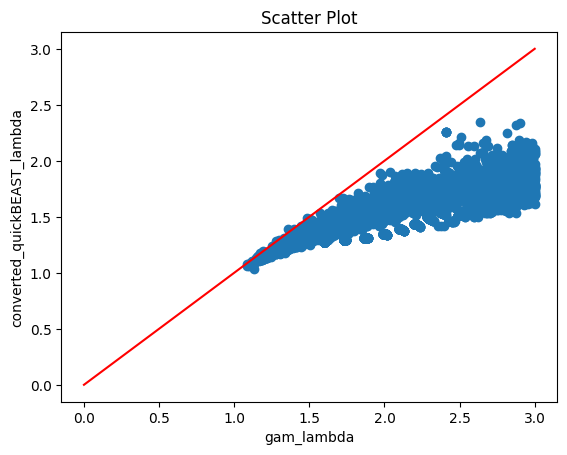

In [18]:
plt.scatter(overlapped["gam_lambda"], overlapped["converted_qB_lambda"])

# Set chart title and label axes
plt.title("Scatter Plot")
plt.xlabel("gam_lambda")
plt.ylabel("converted_quickBEAST_lambda")
plt.plot([0, 3], [0, 3], color='red')
plt.show()  

In [19]:
plt.scatter(overlapped["converted_gam_lambda"], overlapped["quickBEAST_lambda"])

# Set chart title and label axes
plt.title("Scatter Plot")
plt.xlabel("converted_gam_lambda")
plt.ylabel("quickBEAST_lambda")
plt.plot([0, 0.25], [0, 0.25], color='red')
plt.show()  

KeyError: 'converted_gam_lambda'

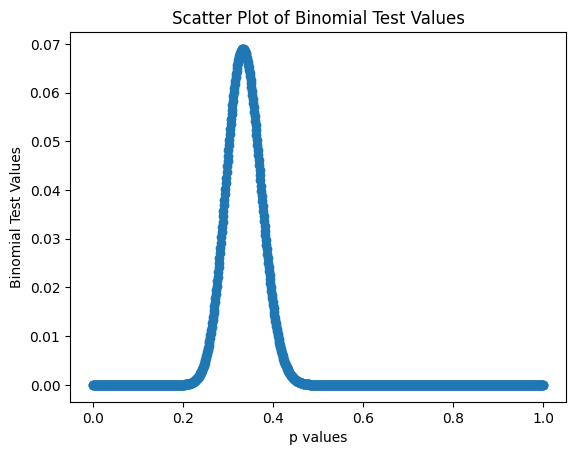

In [20]:


n = 150    # fixed number of trials
x = 50    # fixed number of successes
p_values = np.linspace(0, 1, 1000)     # generate 1000 values of p from 0 to 1
binom_test_values = [binom.pmf(x, n, p) for p in p_values]    # calculate binomial test for each p

# create scatter plot
plt.scatter(p_values, binom_test_values)
plt.title('Scatter Plot of Binomial Test Values')
plt.xlabel('p values')
plt.ylabel('Binomial Test Values')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

def qq_plot_pvalues(p_values):
    # Transform p-values to -log10 scale
    transformed_p_values = -np.log10(p_values)
    
    # Generate theoretical uniform p-values from 0 to 1
    uniform_p_values = np.linspace(0, 1, len(p_values))
    
    # Transform theoretical p-values to -log10 scale
    transformed_uniform_p_values = -np.log10(uniform_p_values[1:-1])  # Avoid log10(0) and log10(1)
    
    # Sort transformed p-values
    sorted_transformed_p_values = np.sort(transformed_p_values)
    
    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_uniform_p_values, sorted_transformed_p_values[1:-1], edgecolor='b', facecolor='none')
    plt.plot([0, max(transformed_uniform_p_values)], [0, max(transformed_uniform_p_values)], 'r--', label='Expected -log10(p)')
    plt.xlabel('Expected -log10(p) (Uniform)')
    plt.ylabel('Observed -log10(p)')
    plt.title('Q-Q Plot of p-values')
    plt.legend()
    plt.grid(True)
    plt.show()


### uniform distribution

(array([524., 470., 509., 522., 515., 456., 529., 473., 522., 445., 496.,
        492., 482., 554., 495., 487., 515., 515., 512., 487.]),
 array([6.86286196e-05, 5.00627797e-02, 1.00056931e-01, 1.50051082e-01,
        2.00045233e-01, 2.50039384e-01, 3.00033535e-01, 3.50027686e-01,
        4.00021837e-01, 4.50015989e-01, 5.00010140e-01, 5.50004291e-01,
        5.99998442e-01, 6.49992593e-01, 6.99986744e-01, 7.49980895e-01,
        7.99975046e-01, 8.49969197e-01, 8.99963348e-01, 9.49957499e-01,
        9.99951651e-01]),
 <BarContainer object of 20 artists>)

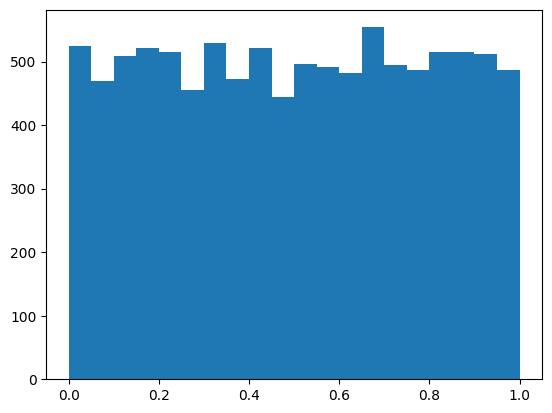

In [3]:
# Example usage
u_p_values = np.random.uniform(0, 1, 10000)
# plot the histogram of p-values
plt.hist(u_p_values, bins=20)


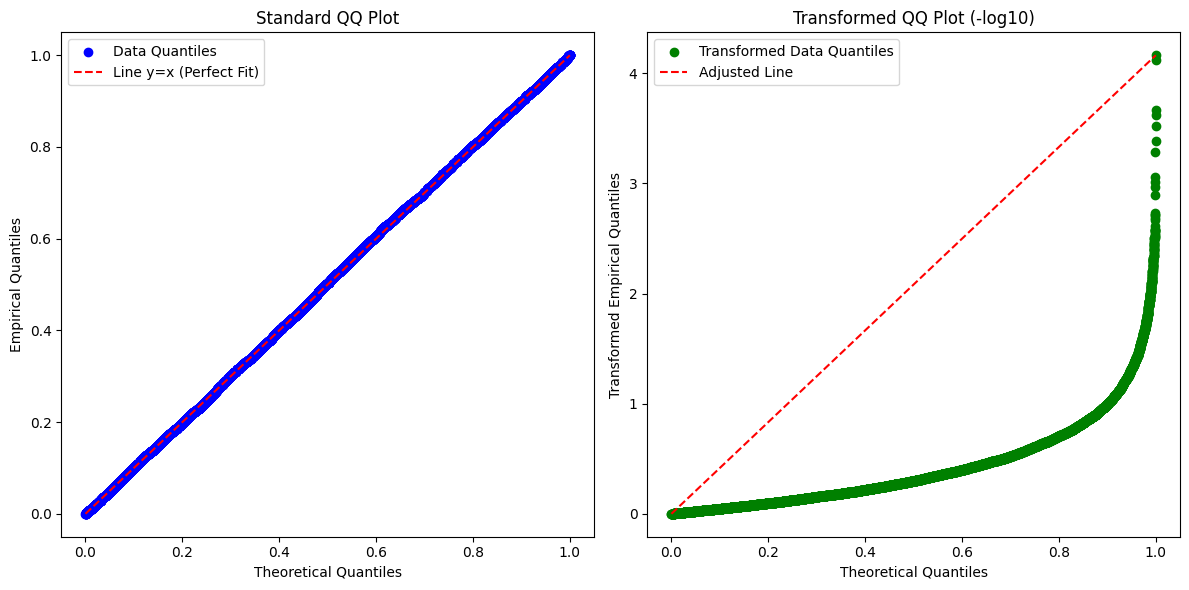

In [8]:
def plot_qq_plots_in_row(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First plot: Standard QQ plot
    theoretical_quantiles = np.linspace(0, 1, num=len(data))
    sorted_data = np.sort(data)
    axes[0].scatter(theoretical_quantiles, sorted_data, color='blue', label='Data Quantiles')
    axes[0].plot([0, 1], [0, 1], 'r--', label='Line y=x (Perfect Fit)')
    axes[0].set_xlabel('Theoretical Quantiles')
    axes[0].set_ylabel('Empirical Quantiles')
    axes[0].set_title('Standard QQ Plot')
    axes[0].legend()

    transformed_data = -np.log10(data)
    theoretical_quantiles_transformed = np.linspace(0, 1, num=len(transformed_data))
    sorted_transformed_data = np.sort(transformed_data)
    axes[1].scatter(theoretical_quantiles_transformed, sorted_transformed_data, color='green', label='Transformed Data Quantiles')
    axes[1].plot([0, 1], [0, max(sorted_transformed_data)], 'r--', label='Adjusted Line')
    axes[1].set_xlabel('Theoretical Quantiles (-log10)')
    axes[1].set_ylabel('Transformed Empirical Quantiles (-log10)')
    axes[1].set_title('Transformed QQ Plot (-log10)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_qq_plots_in_row(u_p_values)

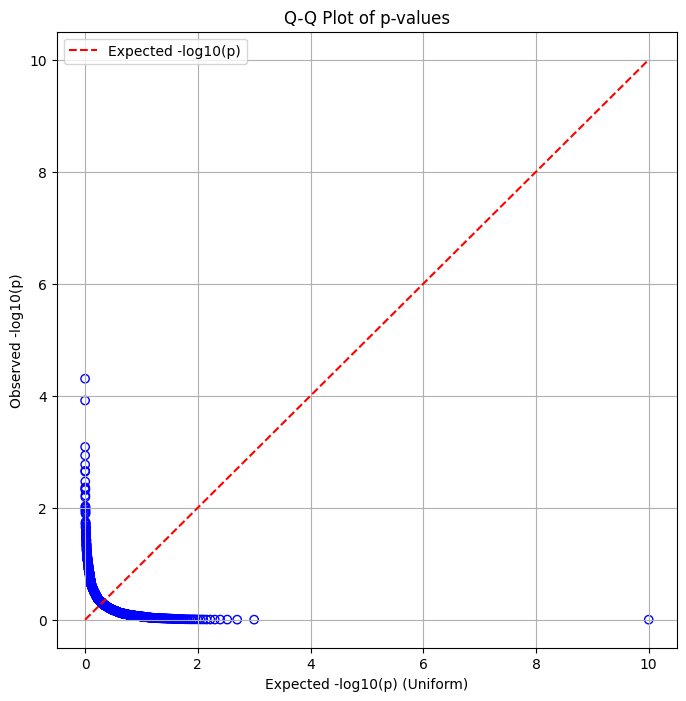

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

def qq_plot_pvalues(p_values, epsilon=1e-10):
    # Transform p-values to -log10 scale, avoiding log10(0) by setting a lower bound
    transformed_p_values = -np.log10(np.maximum(p_values, epsilon))
    
    # Generate theoretical uniform p-values, avoiding 0 and 1
    uniform_p_values = np.linspace(epsilon, 1 - epsilon, len(p_values))
    
    # Transform theoretical p-values to -log10 scale
    transformed_uniform_p_values = -np.log10(uniform_p_values)
    
    # Sort transformed p-values
    sorted_transformed_p_values = np.sort(transformed_p_values)
    
    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_uniform_p_values, sorted_transformed_p_values, edgecolor='b', facecolor='none')
    plt.plot([0, max(transformed_uniform_p_values)], [0, max(transformed_uniform_p_values)], 'r--', label='Expected -log10(p)')
    plt.xlabel('Expected -log10(p) (Uniform)')
    plt.ylabel('Observed -log10(p)')
    plt.title('Q-Q Plot of p-values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
p_values = np.random.uniform(0, 1, 1000)
qq_plot_pvalues(p_values)


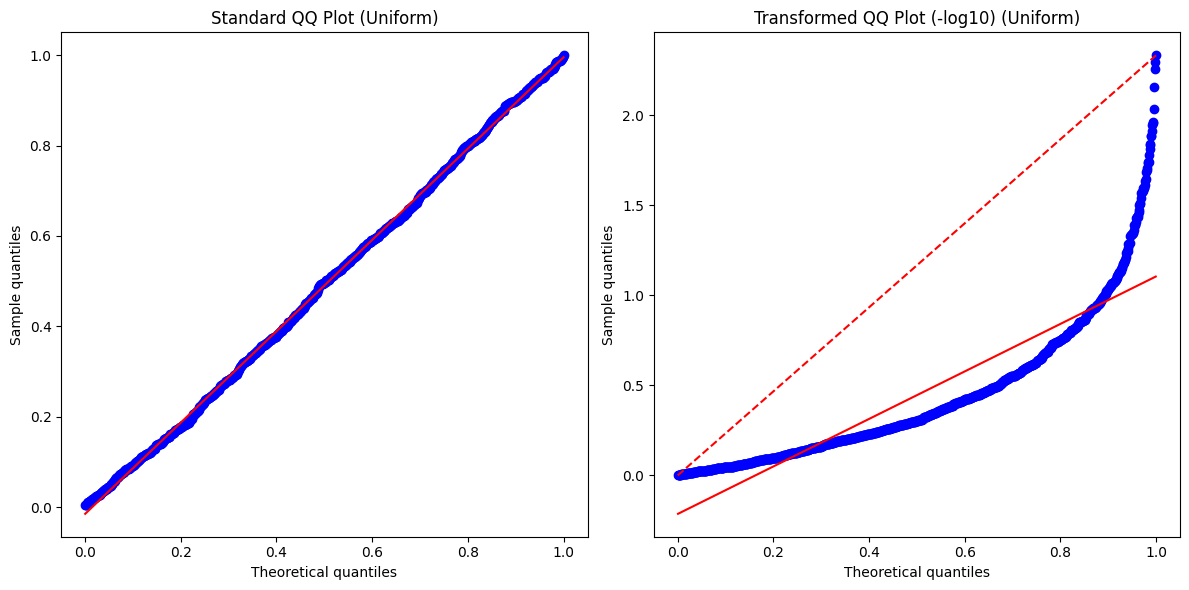

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generating p-values following a uniform distribution
np.random.seed(42)  # For reproducibility
p_values = np.random.uniform(low=0, high=1, size=1000)

# Function to plot QQ plots on the same row with transformation handling
def qq_plots_in_row(data, transformation=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First plot: Standard QQ plot
    stats.probplot(data, dist="uniform", plot=axes[0])
    axes[0].set_title('Standard QQ Plot (Uniform)')
    axes[0].set_xlabel('Theoretical quantiles')
    axes[0].set_ylabel('Sample quantiles')

    # Second plot: Transformed QQ plot (-log10)
    if transformation:
        transformed_data = transformation(data)
        stats.probplot(transformed_data, dist="uniform", plot=axes[1])
        max_val = max(np.max(transformed_data), np.max(np.sort(np.random.uniform(low=0, high=1, size=len(data)))))
        axes[1].plot([0, 1], [0, max_val], 'r--')  # Red dashed line extending to the right top corner
    axes[1].set_title('Transformed QQ Plot (-log10) (Uniform)')
    axes[1].set_xlabel('Theoretical quantiles')
    axes[1].set_ylabel('Sample quantiles')

    plt.tight_layout()
    plt.show()

# Plotting both QQ plots in the same row
qq_plots_in_row(p_values, transformation=lambda x: -np.log10(x))


### check type1error

In [3]:

def Table_power_type1error(POS,NEG,path,alpha_beta,type1error,lambdas = None):
    beastie_power,beastie_qb_power,qb_power,beastie_type1error,beastie_qb_type1error,qb_type1error = Calculate_power_type1error(POS,NEG,path,alpha_beta,type1error,lambdas=lambdas)
    # Plotting the histograms
    print((f"BEASTIE-GAMlambda power = ALT (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  power = ALT (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                power = ALT (qB posterior) > 0.5"))
    print((f"BEASTIE-GAMlambda type1error = REF (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  type1error = REF (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                type1error = REF (qB posterior) > 0.5"))
    Table = PrettyTable(["sample Name", "BEASTIE-GAMlambda (power)", "BEASTIE-qBlambda (power)","qB (power)","BEASTIE-GAMlambda (type1er)", "BEASTIE-qBlambda (type1er)","qB (type1er)"])
    Table.add_row([os.path.splitext(NEG)[0], beastie_power,beastie_qb_power,qb_power,beastie_type1error, beastie_qb_type1error,qb_type1error])
    print(Table)

def print_single_table(n_hets,n_depth,alt,alpha_beta,sigma,expected_type1error):
    print(f">>>> expected type1error at {expected_type1error}, alpha/beta parameter at {alpha_beta}")
    
    model="BEASTIE3-pi0.05"
    path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    POS=f"g-1000_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"

    DCC_path="/data2/stan"
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open("/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE4_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)
    print(f"predicted lambda is {predicted_lambda}")
    Table_power_type1error(POS,NEG,path,alpha_beta,expected_type1error,lambdas=predicted_lambda)


# Function to calculate 95% CI
def compute_CI(mean, std, n):
    margin = 1.96 * (std / (n ** 0.5))
    return (mean - margin, mean + margin)

from scipy.stats import norm


def plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error):
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    BEASTIE,qb = get_z(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error)
    BEASTIE_mean = calculate_posterior_value("mean",BEASTIE)
    BEASTIE_var = calculate_posterior_value("var",BEASTIE)
    BEASTIE_std = calculate_posterior_value("std",BEASTIE)
    BEASTIE_zscore = calculate_posterior_value("z",BEASTIE)
    qb_mean = qb['qb_mean'].tolist()
    qb_var = qb['qb_var'].tolist()
    qb_std = np.sqrt(qb_var)
    qb_z = qb['qb_zscore'].tolist()
    # Compute summary for Method 1 (iBEASTIE4)
    mean_1_avg = sum(BEASTIE_mean) / len(BEASTIE_mean)
    var_1_avg = sum(BEASTIE_var) / len(BEASTIE_var)
    std_1_avg = sum(BEASTIE_std) / len(BEASTIE_std)
    z_1_avg = sum(BEASTIE_zscore) / len(BEASTIE_zscore)
    # Get parameters of the fitted distribution for iBEASTIE4
    mu, std = norm.fit(BEASTIE_zscore)

    # Compute summary for Method 2 (qB)
    mean_2_avg = sum(qb_mean) / len(qb_mean)
    var_2_avg = sum(qb_var) / len(qb_var)
    std_2_avg = sum(qb_std) / len(qb_std)
    z_2_avg = sum(qb_z) / len(qb_z)
    
    # Printing the table
    Table = PrettyTable([os.path.splitext(NEG)[0], "mean from 1000 datapts", "var from 1000 datapts", "std from 1000 datapts", "Z(MEAN/STD)"])
    Table.add_row(["iBEASTIE4", format(mean_1_avg,'.5f'), format(var_1_avg,'.5f'), format(std_1_avg,'.5f'), format(z_1_avg,'.5f')])
    Table.add_row(["qB", format(mean_2_avg,'.5f'), format(var_2_avg,'.5f'), format(std_2_avg,'.5f'), format(z_2_avg,'.5f')])
    print(Table)

# Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5)) # 1 row, 3 columns

    # Plot for Mean
    axs[0].hist(BEASTIE_mean, bins=30, alpha=.5)
    axs[0].hist(qb_mean, bins=30, alpha=.5)
    axs[0].set_title(f"Mean of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[0].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot for Std (assuming you want to plot the square root of var as std)
    axs[1].hist(BEASTIE_std, bins=30, alpha=.5)
    axs[1].hist(qb_std, bins=30, alpha=.5)
    axs[1].set_title(f"Std of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[1].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot for Z Scores
    axs[2].hist(BEASTIE_zscore, bins=30, alpha=.5, label='iBEASTIE4')
    axs[2].hist(qb_z, bins=30, alpha=.5, label='qB')
    axs[2].set_title(f"Z (MEAN/STD) of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[2].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot PDFs of fitted and original distributions from 1000 NULL genes
    qb_z_1000 = simulate_null_genes(n_hets, n_depth, pi=0.05)
    null_mean = np.mean(qb_z_1000)
    null_std = np.std(qb_z_1000)
    fitted_mean, fitted_std = norm.fit(qb_z_1000)  # Fitting qB z-scores to a normal distribution

    xmin, xmax = axs[2].get_xlim()  # Get xlim from the Z Scores plot
    x = np.linspace(xmin, xmax, 100)
    p_null = norm.pdf(x, null_mean, null_std)
    axs[3].plot(x, p_null, 'k--', linewidth=2, label=f"fitted norm with MLE parameters:\n mu={null_mean:.2f} std={null_std:.2f}")
    p_fitted = norm.pdf(x, fitted_mean, fitted_std)
    axs[3].plot(x, p_fitted, 'r--', linewidth=2, label=f"normal with qb Zscore parameters:\n mean={fitted_mean:.2f} std={fitted_std:.2f}")
    axs[3].set_title("PDFs for 1000 qB Z (MEAN/STD)",fontsize=15)
    axs[3].legend(loc="upper right",fontsize=13)

    plt.tight_layout()
    plt.show()

def simulate_null_genes(number_of_hets, average_read_depth_per_het, pi=0.05):
    # SIMULATE GENE INPUTS
    NUM_GENES = 1
    simulated_genes = []
    for i in range(NUM_GENES):
        gene_id = f"gene_{i}"
        simulated_genes.append(generate_fields(gene_id, M=number_of_hets, D=average_read_depth_per_het, theta=1, switching_error = pi))

    # RUN qb simulated genes 
    simulated_gene_results = run_qb_parallel(simulated_genes)

    # compute summary statistics
    #mean = simulated_gene_results["qb_zscore"].mean()
    #std = simulated_gene_results["qb_zscore"].std()
    qb_z = simulated_gene_results["qb_zscore"].tolist()
    #mean, std = norm.fit(qb_z)
    return qb_z

import subprocess
import tempfile
import logging
import shutil

def write_genes_to_quickbeast_input_file(genes, file_path):
    with open(file_path, 'w') as file:
        for gene in genes:
            gene_id = gene[0]
            hets = gene[1]
            data = gene[2:2+(2*hets)]
            
            file.write(f'(gene {gene_id} (theta 1.0) ')
            
            for i in range(hets):
                mat = data[i*2]
                pat = data[(i*2)+1]
                file.write(f'(site {i+1} (mat {mat}) (pat {pat}) (phaseCorrect 1)) ')
            
            file.write(")\n")

def run_qb_parallel(genes):
    parameter = 8.789625
    type1error = 0.05
    lambdas = 0.04545

    # prepare files
    temp_dir = tempfile.mkdtemp()
    input_file_path = os.path.join(temp_dir, f'input.txt')
    output_file_path = os.path.join(temp_dir, f"output.txt")

    write_genes_to_quickbeast_input_file(genes, input_file_path)
    #run qb
    try:
        subprocess.run([f"/home/scarlett/github/RNAseq-analysis/run_quickBeast/quick_beast_parallel.sh {input_file_path} {parameter} {type1error} {lambdas} > {output_file_path}"], check=True, shell=True)
        # logging.info(f"QB for {input_file_path} executed successfully")
    except subprocess.CalledProcessError as e:
        logging.error(f"Error running QB for {input_file_path}: {e}")

    #read and convert results
    qb = pd.read_csv(output_file_path, delimiter="\t", header=None)
    qb.columns = ['geneID', 'qb_posterior', 'qb_lambda', 'qb_mean', 'qb_var', 'qb_zscore']
    
    # cleanup
    shutil.rmtree(temp_dir)

    return qb

def generate_fields(geneID,M, D, theta,switching_error = 0.05):
    # calculate probability for binomial distribution
    p = theta / (1.0 + theta)
    # calculate alternative and reference read counts for each het
    alt_counts = np.random.binomial(D, p, M)
    ref_counts = D - alt_counts
    # construct output fields
    switched = False
    fields = [geneID, M]
    
    for counts in zip(alt_counts, ref_counts):
        if switched:
            fields.append(counts[1])
            fields.append(counts[0])
        else:
            fields.append(counts[0])
            fields.append(counts[1])
        if np.random.uniform() <= switching_error:
            switched = not switched
    
    # Adding number of missing pi and phasing error fields
    fields.append("0")  # Number of missing pi
    fields += [switching_error] * (M - 1)  # Phasing error (We assume all pairs to be -1)

    return fields

def compare_power_type1error(n_gene,n_hets,n_depth,alt,alpha_beta,lambdas,sigma):
    print(f">>>> QB: lambda fixed, alpha/beta parameter at {alpha_beta}")
    print(f">>>> BEASTIE3-pi0.05: lambda 0.7")

    model="BEASTIE3-pi0.05"
    BEASITE_path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
    qb_path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
    NS_path="/data2/stan/binomial/parametrized/ASE_0.05_error/NS_p"
    b_NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    b_POS=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle" 

    Table_pval_power_type1error(b_POS,b_NEG,BEASITE_path,qb_path,NS_path)

import re 

def Calculate_bonferroni_power_type1error(POS,NEG,threshold=0.05):
    cutoff = threshold/len(POS)
    power = len([i for i in POS if float(i) <= cutoff]) / len(POS)
    # false positive 
    type1error = len([i for i in NEG if float(i) <= cutoff]) / len(NEG)
    return power,type1error


def Calculate_FDR_power_type1error(POS, NEG, threshold=0.05):
    _, corrected_POS, _, _ = multipletests(POS, method='fdr_bh')
    
    # Perform FDR correction using Benjamini-Hochberg method for NEG
    _, corrected_NEG, _, _ = multipletests(NEG, method='fdr_bh')

    # Calculate power and type I error based on the corrected p-values
    power = (corrected_POS <= threshold).sum() / len(POS)
    type1error = (corrected_NEG <= threshold).sum() / len(NEG)

    return power, type1error

def get_filename(b_POS,b_NEG):
    ns_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG)
    ns_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS)
    qb_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG).replace('.pickle', '.txt')
    qb_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS).replace('.pickle', '.txt')
    return ns_NEG,ns_POS,qb_NEG,qb_POS

def Table_pval_power_type1error(b_POS,b_NEG,BEASITE_path,qb_path,NS_path,n_simulation=1000):
    ns_NEG,ns_POS,qb_NEG,qb_POS = get_filename(b_POS,b_NEG)
    qb_POS_p, qb_NEG_p = get_qb_p_values(qb_POS, qb_NEG, qb_path)
    ns_POS_p, ns_NEG_p = get_NS_p_values(ns_POS, ns_NEG, NS_path)
    qb_power, qb_type1error = Calculate_bonferroni_power_type1error(qb_POS_p,qb_NEG_p,threshold=0.05)
    ns_power, ns_type1error = Calculate_bonferroni_power_type1error(ns_POS_p,ns_NEG_p,threshold=0.05)
    fdr_qb_power, fdr_qb_type1error = Calculate_FDR_power_type1error(qb_POS_p,qb_NEG_p,threshold=0.05)
    fdr_ns_power, fdr_ns_type1error = Calculate_FDR_power_type1error(ns_POS_p,ns_NEG_p,threshold=0.05)
    # Plotting the histograms
    print((f"qB   bonferroni   power      = ALT (qB pval) <= {0.05/len(qb_POS_p)}"))
    print((f"qB   bonferroni   type1error = REF (qB pval) <= {0.05/len(qb_POS_p)}"))
    print((f"NS   bonferroni   power      = ALT (NS pval) <= {0.05/len(ns_POS_p)}"))
    print((f"NS   bonferroni   type1error = REF (NS pval) <= {0.05/len(ns_POS_p)}"))
    print((f"qB   FDR          power      = ALT (qB pval) <= 0.05"))
    print((f"qB   FDR          type1error = REF (qB pval) <= 0.05"))
    print((f"NS   FDR          power      = ALT (NS pval) <= 0.05"))
    print((f"NS   FDR          type1error = REF (NS pval) <= 0.05"))
    Table = PrettyTable([f"{os.path.splitext(qb_NEG)[0]} & {os.path.splitext(qb_POS)[0]}", "(pval) power", "(pval) type1error"])
    Table.add_row(["(bonferroni) qB fixed lambda", 
                   format(qb_power,'.5f'),
                   format(qb_type1error,'.5f')])
    Table.add_row(["(bonferroni) Naive Sum", 
                   format(ns_power,'.5f'),
                   format(ns_type1error,'.5f')])
    Table.add_row(["(FDR) qB fixed lambda", 
                   format(fdr_qb_power,'.5f'),
                   format(fdr_qb_type1error,'.5f')])
    Table.add_row(["(FDR) Naive Sum", 
                   format(fdr_ns_power,'.5f'),
                   format(fdr_ns_type1error,'.5f')])
    print(Table)




In [4]:
def qq_skewed_t(data):
    # Convert data to numpy array
    data_array = np.array(data)
    
    # Fit data to a skewed t-distribution to get the parameters
    params = skewnorm.fit(data_array)
    
    # Extract the shape, location, and scale parameters
    shape, loc, scale = params
    
    # Generate random variates from the fitted skewed t-distribution
    fitted_data = skewnorm.rvs(shape, loc, scale, size=len(data_array))
    
    # Calculate the theoretical quantiles for the skewed t-distribution using the fitted parameters
    sorted_data = np.sort(data_array)
    
    # Calculate the theoretical quantiles for the fitted data
    fitted_sorted_data = np.sort(fitted_data)
    fitted_sorted_quantiles = np.arange(1, len(fitted_sorted_data) + 1) / (len(fitted_sorted_data) + 1)
    fitted_theoretical_quantiles = skewnorm.ppf(fitted_sorted_quantiles, shape, loc, scale)
    
    # Create a QQ plot using statsmodels qqplot
    sm.qqplot(sorted_data, dist=skewnorm, line='45', fit=True, distargs=params)
    
    plt.title('QQ plot against Skewed t-distribution')
    plt.show()

def qq_standard_t(data):
    # Convert data to numpy array
    data_array = np.array(data)
    
    # Fit data to a standard t-distribution to get the degrees of freedom parameter
    df, loc, scale = t.fit(data_array)
    
    # Create a QQ plot using probplot for a standard t-distribution
    sm.qqplot(data_array, dist=t, loc=loc, scale=scale, line='45', fit=True)
    
    plt.title('QQ plot against Standard t-distribution')
    plt.show()

def qq_normal(data):
    # Convert data to numpy array
    data_array = np.array(data)
    
    # Create a QQ plot using probplot for a normal distribution
    sm.qqplot(data_array, line='45', fit=True)
    
    plt.title('QQ plot against Normal Distribution')
    plt.show()


In [7]:
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1

BEASTIE,qb = get_z(n_hets,n_depth,theta,alpha_beta,sigma)
b_z = calculate_posterior_value("z",BEASTIE)
qb_z = pd.to_numeric(qb["qb_zscore"], errors='coerce').dropna().tolist()

>>>> alpha/beta parameter at 8.789625


In [34]:
qb_z

[1.12275,
 1.58384,
 1.25326,
 0.612111,
 -0.304116,
 0.000227497,
 0.652594,
 -0.100766,
 -0.295997,
 0.0632985,
 -1.06271,
 -0.778301,
 -0.0466357,
 0.0495817,
 0.133955,
 -0.996937,
 -0.510471,
 1.2717,
 -0.83893,
 -0.233744,
 -0.438532,
 -0.771753,
 -0.338034,
 -1.69063,
 0.391583,
 -0.261039,
 0.312454,
 -0.0261,
 -0.212676,
 0.627883,
 0.113341,
 -0.0125811,
 0.02167,
 0.362981,
 -0.0749367,
 0.108426,
 -0.721089,
 -0.100642,
 -0.0117405,
 -0.597349,
 0.63842,
 1.09784,
 0.683669,
 -0.286427,
 0.666001,
 1.53454,
 -0.344122,
 -0.636004,
 0.661909,
 -0.0743392,
 0.764308,
 0.483817,
 0.161781,
 1.16319,
 0.688189,
 0.296189,
 -0.0541932,
 0.137709,
 -0.375508,
 0.100328,
 0.79037,
 -0.459744,
 -0.165227,
 -1.76142,
 0.622414,
 -1.08229,
 -0.700084,
 -1.39445,
 0.897506,
 -0.0362965,
 0.108599,
 -0.570532,
 -0.728477,
 -1.04513,
 0.618749,
 -0.0989746,
 0.147707,
 0.0694651,
 0.181406,
 -2.01951,
 0.0610003,
 0.639266,
 -0.0454841,
 -0.56196,
 -0.30109,
 -0.108233,
 -0.356406,
 -0.

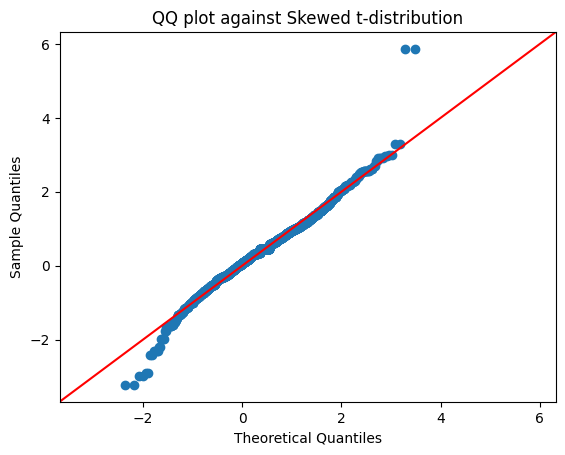

In [8]:
qq_skewed_t(qb_z)


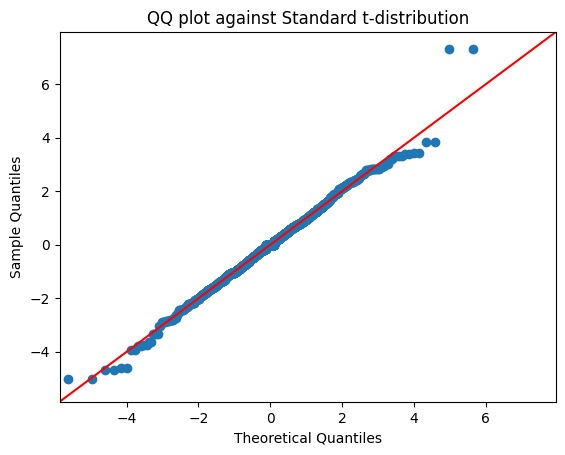

In [9]:
qq_standard_t(qb_z)

In [10]:
qq_norm(qb_z)

NameError: name 'qq_norm' is not defined

In [5]:

def plot_qq_standard_t(data, ax):
    data_array = np.array(data)
    df, loc, scale = t.fit(data_array)
    sm.qqplot(data_array, dist=t, loc=loc, scale=scale, line='45', fit=True, ax=ax,label='qb Zscore')
    ax.legend()
    ax.set_title('QQ plot against t-distribution')

def plot_qq_norm(data, ax):
    data_array = np.array(data)
    #transformed_data = -np.log10(data_array)
    sm.qqplot(data_array, line='45', fit=True, ax=ax,label='qb Zscore')
    ax.legend()
    ax.set_title('QQ plot against normal distribution')


def plot_qq_skewed_t(data, ax):
    # Convert data to numpy array
    data_array = np.array(data)
    # Fit data to a skewed t-distribution to get the parameters
    params = skewnorm.fit(data_array)
    sorted_data = np.sort(data_array)
    sm.qqplot(sorted_data, dist=skewnorm, line='45', fit=True, distargs=params, ax=ax,label='qb Zscore')
    ax.legend()
    ax.set_title('QQ plot against skewed t distribution')

def plot_QQ(qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma):
    NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    qb = get_z(qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)
    #BEASTIE_zscore = calculate_posterior_value("z",BEASTIE)
    qb_z = pd.to_numeric(qb["qb_zscore"], errors='coerce').dropna().tolist()

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5)) # 1 row, 3 columns

    # Plot for Z Scores
    #axs[0].hist(BEASTIE_zscore, bins=30, alpha=.5, label='iBEASTIE4')
    axs[0].hist(qb_z, bins=30, alpha=.5, label='qB Zscore')
    axs[0].set_title(f"Z (MEAN/STD) of {os.path.splitext(NEG)[0]}",fontsize=15)
    #axs[0].legend(['iBEASTIE4', 'qB'],fontsize=13)
    axs[0].legend()
    plot_qq_norm(qb_z, axs[1])
    plot_qq_standard_t(qb_z, axs[2])
    plot_qq_skewed_t(qb_z, axs[3])

    plt.tight_layout()
    plt.show()

In [7]:
n_hets=1
n_depth=5
theta=1
alpha_beta=8.789625
sigma=0.7
n_gene=1000
theta=1 

plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

TypeError: plot_QQ() missing 1 required positional argument: 'sigma'

>>>> alpha/beta parameter at 8.789625


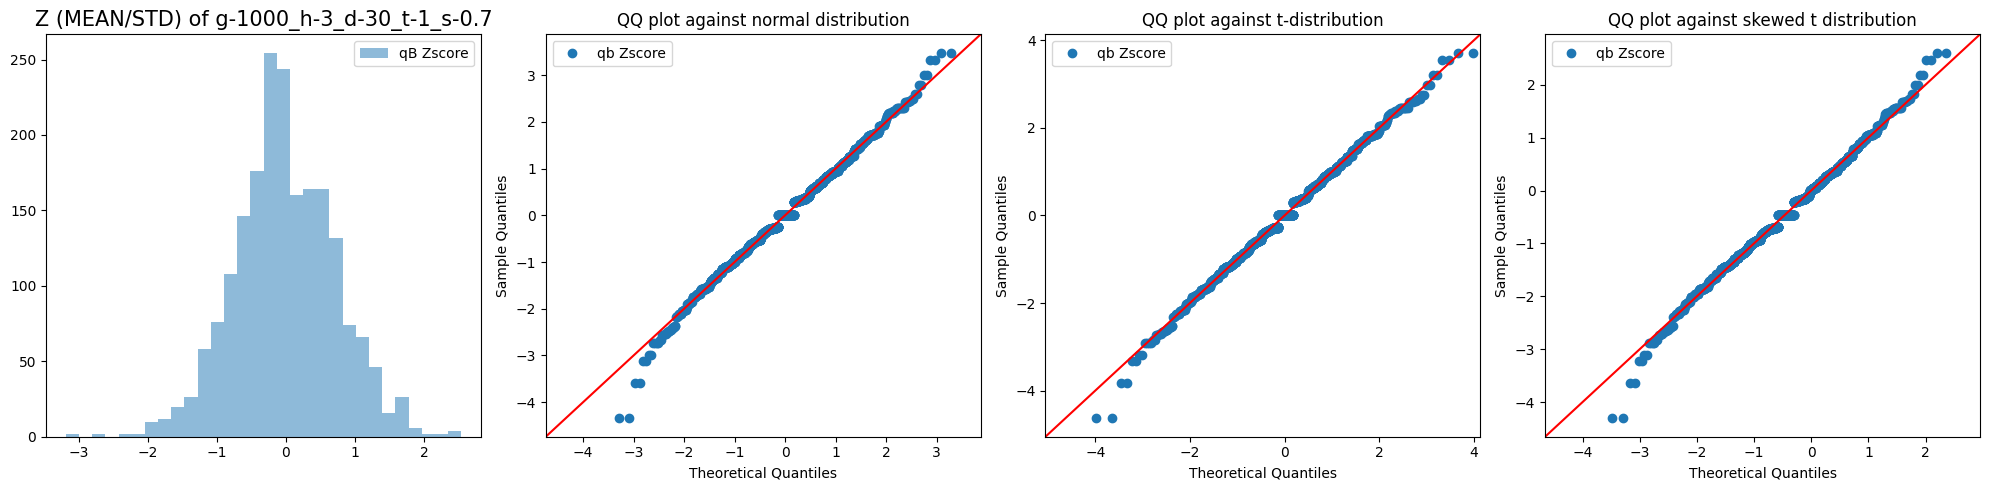

In [13]:
n_hets=3
n_depth=30
theta=1
alpha_beta=8.789625
sigma=0.7
n_gene=1000
plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

>>>> alpha/beta parameter at 8.789625


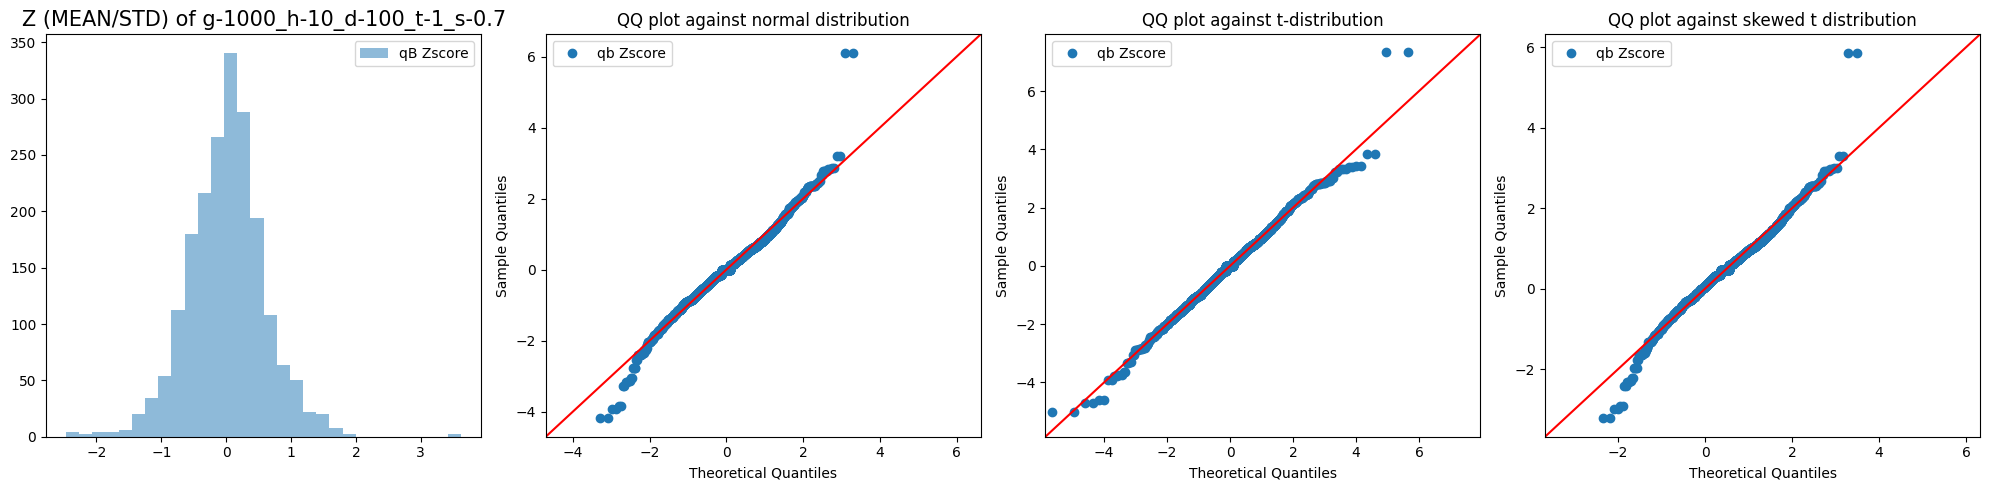

In [14]:
n_hets=10
n_depth=100
theta=1
alpha_beta=8.789625
sigma=0.7
n_gene=1000
plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

In [15]:
n_gene=19207904
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

>>>> alpha/beta parameter at 8.789625


/home/scarlett/github/Ipy_notebook/Python/quickBeast.py:88: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  qb=pd.read_csv(f"/data2/stan/quickBEAST/a{parameter}_b{parameter}/lambda0.04545/parametrized/ASE_0.05_error/{qb_filename}.txt",delimiter="\t",header=None)


ValueError: Length mismatch: Expected axis has 9 elements, new values have 7 elements

>>>> alpha/beta parameter at 8.789625


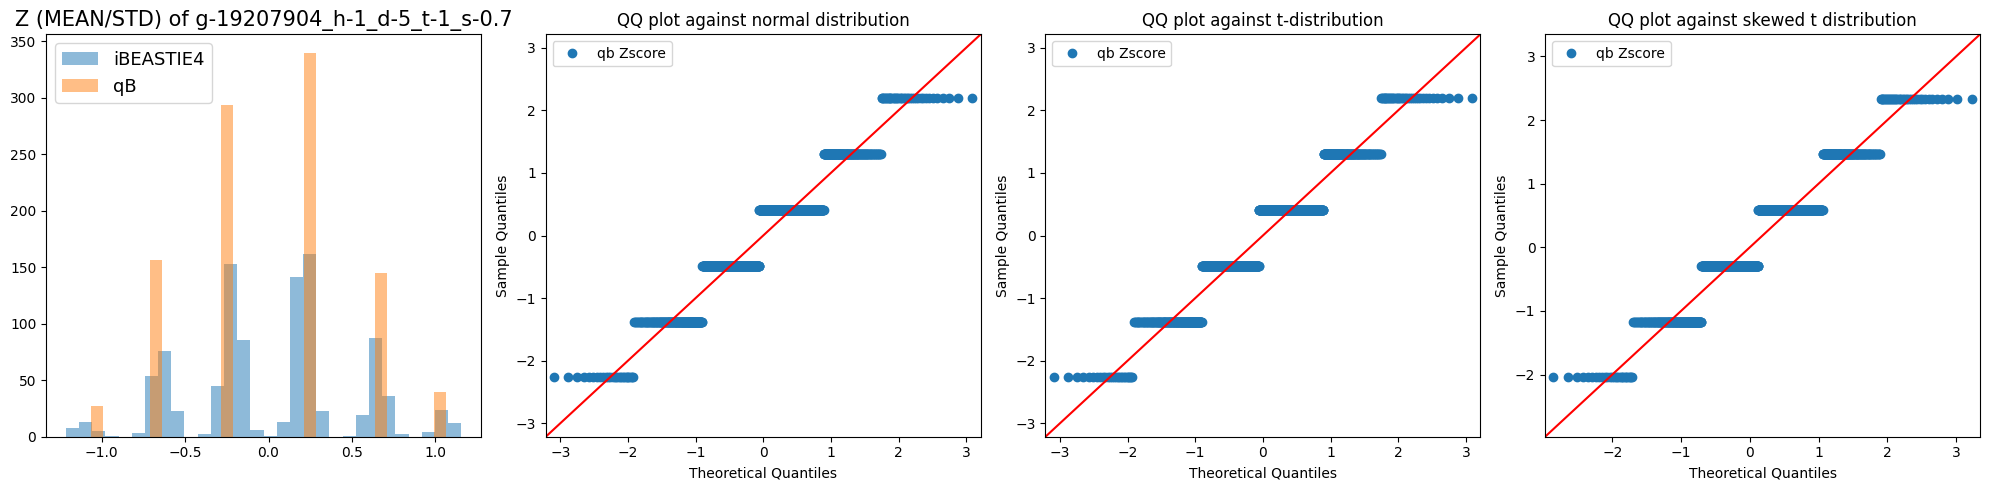

In [ ]:
n_gene=19207904
n_hets=1
n_depth=5
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

>>>> alpha/beta parameter at 8.789625


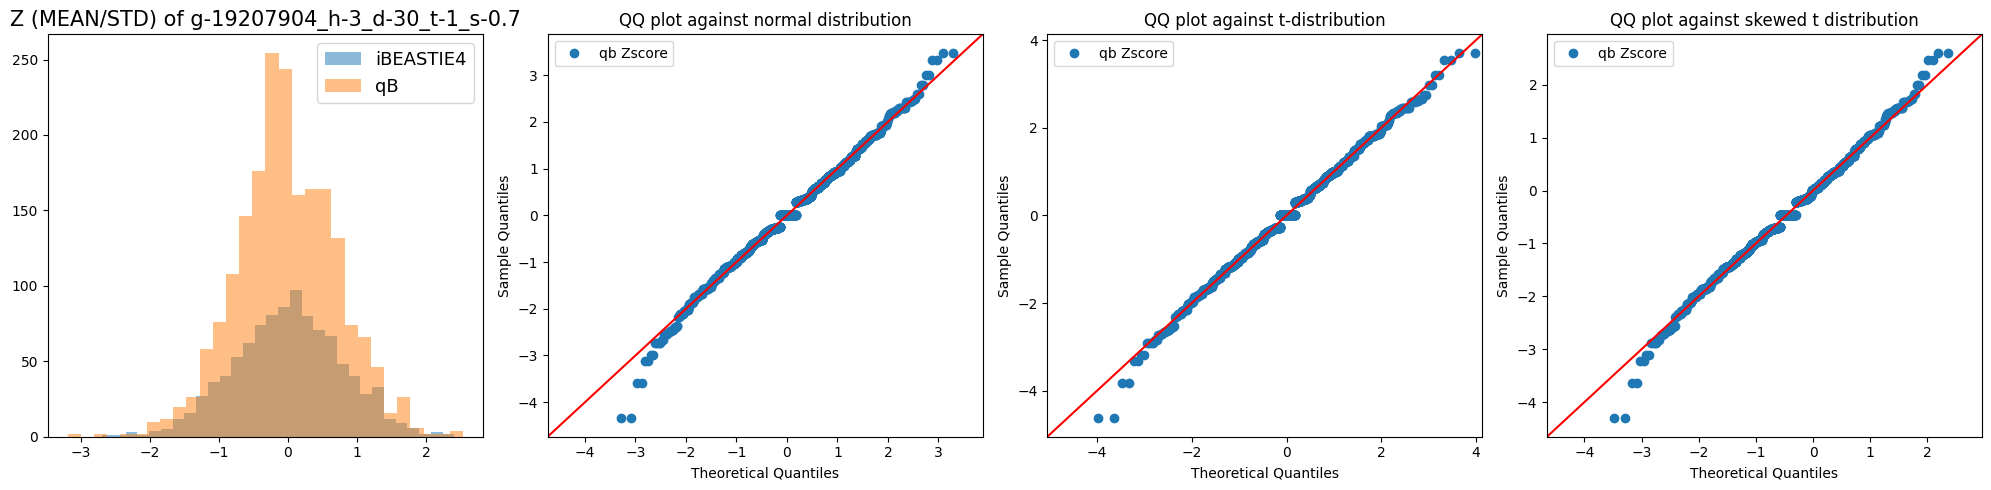

In [ ]:
n_gene=19207904
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
plot_QQ(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

In [6]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

def plot_qq_standard_t_log10(data, ax,label):
    data_array = np.array(data)
    df, loc, scale = t.fit(data_array)
    
    # Shift the values to make them all positive or zero
    min_value = min(data_array)  # Find the minimum value in your data
    shift_constant = max(0, -min_value)  # Choose a shift constant to make all values non-negative
    shifted_data = data_array + shift_constant
    
    # Apply the -log10 transformation to the shifted data
    transformed_data = -np.log10(shifted_data)
    
    # Remove non-finite values (NaN or Inf)
    transformed_data = transformed_data[np.isfinite(transformed_data)]
    
    sm.qqplot(transformed_data, dist=t, loc=loc, scale=scale, line='45', fit=True, ax=ax, label=label)
    ax.legend()
    ax.set_title('QQ plot (-log10 scale) against t-distribution')

def plot_qq_norm_log10(data, ax,label):
    data_array = np.array(data)
    
    # Shift the values to make them all positive or zero
    min_value = min(data_array)  # Find the minimum value in your data
    shift_constant = max(0, -min_value)  # Choose a shift constant to make all values non-negative
    shifted_data = data_array + shift_constant
    
    # Apply the -log10 transformation to the shifted data
    transformed_data = -np.log10(shifted_data)
    
    # Remove non-finite values (NaN or Inf)
    transformed_data = transformed_data[np.isfinite(transformed_data)]
    
    sm.qqplot(transformed_data, line='45', fit=True, ax=ax, label=label)
    ax.legend()
    ax.set_title('QQ plot (-log10 scale) against normal distribution')

def plot_qq_skewed_t_log10(data, ax,label):
    data_array = np.array(data)
    
    # Shift the values to make them all positive or zero
    min_value = min(data_array)  # Find the minimum value in your data
    shift_constant = max(0, -min_value)  # Choose a shift constant to make all values non-negative
    shifted_data = data_array + shift_constant
    
    # Apply the -log10 transformation to the shifted data
    transformed_data = -np.log10(shifted_data)
    
    # Remove non-finite values (NaN or Inf)
    transformed_data = transformed_data[np.isfinite(transformed_data)]
    
    params = skewnorm.fit(transformed_data)
    sorted_data = np.sort(transformed_data)
    sm.qqplot(transformed_data, dist=skewnorm, line='45', fit=True, distargs=params, ax=ax, label=label)
    ax.legend()
    ax.set_title('QQ plot (-log10 scale) against skewed t distribution')

def  plot_QQ_log10(label,path_qb,n_gene, n_hets, n_depth, theta, alpha_beta, sigma):
    print(path_qb)
    NEG = f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    qb = get_z(path_qb,n_gene,n_hets, n_depth, theta, alpha_beta, sigma)
    #BEASTIE_zscore = calculate_posterior_value("z", BEASTIE)
    qb_z = pd.to_numeric(qb[label], errors='coerce').dropna().tolist()

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5)) # 1 row, 3 columns

    # Plot for Z Scores
    #axs[0].hist(BEASTIE_zscore, bins=30, alpha=.5, label='iBEASTIE4')
    axs[0].hist(qb_z, bins=30, alpha=.5, label=label)
    axs[0].set_title(f"{label} of {os.path.splitext(NEG)[0]}",fontsize=15)
    #axs[0].legend(['iBEASTIE4', 'qB'],fontsize=13)
    axs[0].legend()

    plot_qq_norm_log10(qb_z, axs[1],label)
    plot_qq_standard_t_log10(qb_z, axs[2],label)
    plot_qq_skewed_t_log10(qb_z, axs[3],label)

    plt.tight_layout()
    plt.show()

def get_z(path_qb,n_gene,n_hets,n_depth,theta,alpha_beta,sigma):
    print(path_qb)
    print(f">>>> alpha/beta parameter at {alpha_beta}")
    
    model="iBEASTIE4"
    NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"

    DCC_path="/data2/stan"
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open("/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE4_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    #predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)
    #BEASTIE,qb = get_data(NEG,path,alpha_beta)
    qb = get_data(NEG,path_qb)
    return qb

def get_data(filename,path_qb):
    print(path_qb)
    base_filename = os.path.splitext(filename)[0] # remove extension
    parts = base_filename.split('_') # split by underscore
    qb_filename = '_'.join(parts[:-1])
    # read data
    qb=pd.read_csv(f"{path_qb}/{qb_filename}.txt",delimiter="\t",header=0)
    #qb.columns=['geneID','qb_mean','qb_var','qb_zscore']
    return qb


In [14]:
# n_gene=19207904
# n_hets=3
# n_depth=30
# alt=0.5
# alpha_beta=8.789625
# lambdas=0.04545
# sigma=0.7

# plot_QQ_log10(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

In [15]:
# n_gene=19207904
# n_hets=10
# n_depth=100
# alt=0.5
# alpha_beta=8.789625
# lambdas=0.04545
# sigma=0.7
# plot_QQ_log10(n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2480962/3517357310.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2480962/3517357310.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2480962/3517357310.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


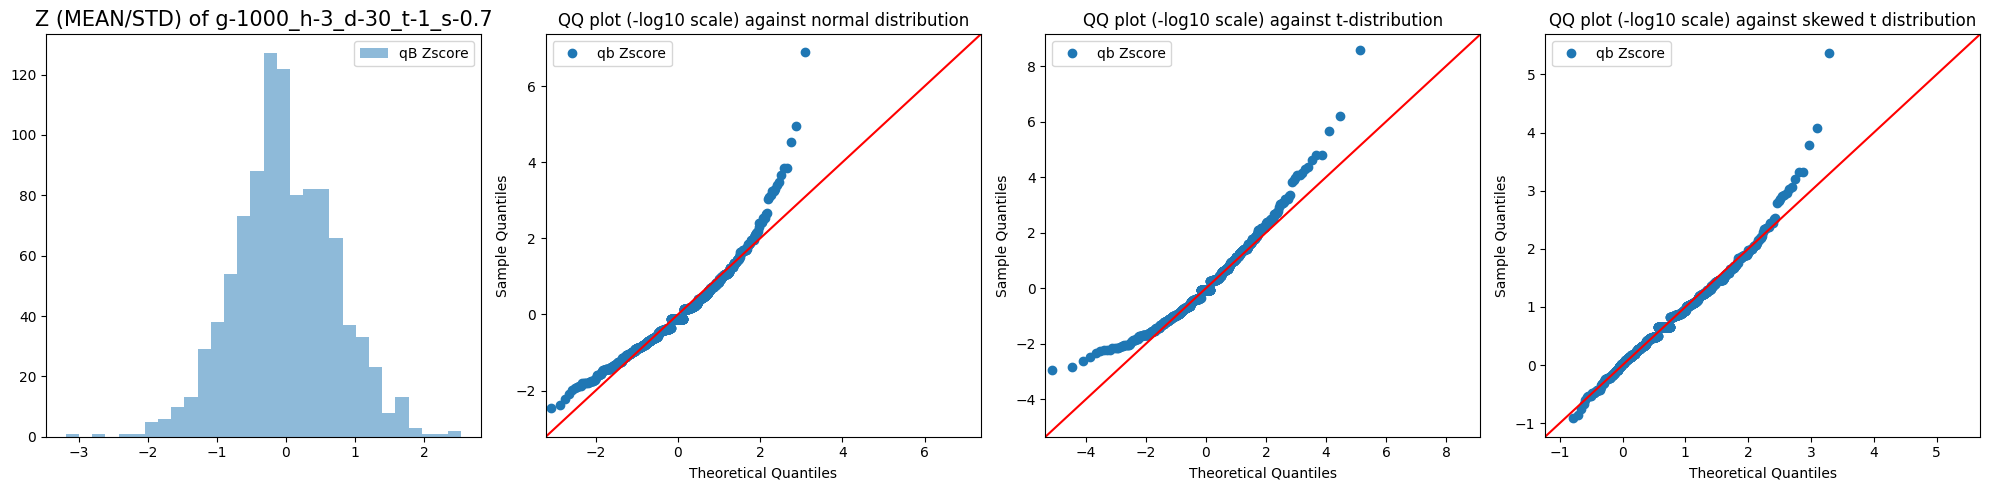

In [18]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
path_qb=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error/withcache"

plot_QQ_log10(path_qb,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2465156/3645803999.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2465156/3645803999.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2465156/3645803999.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


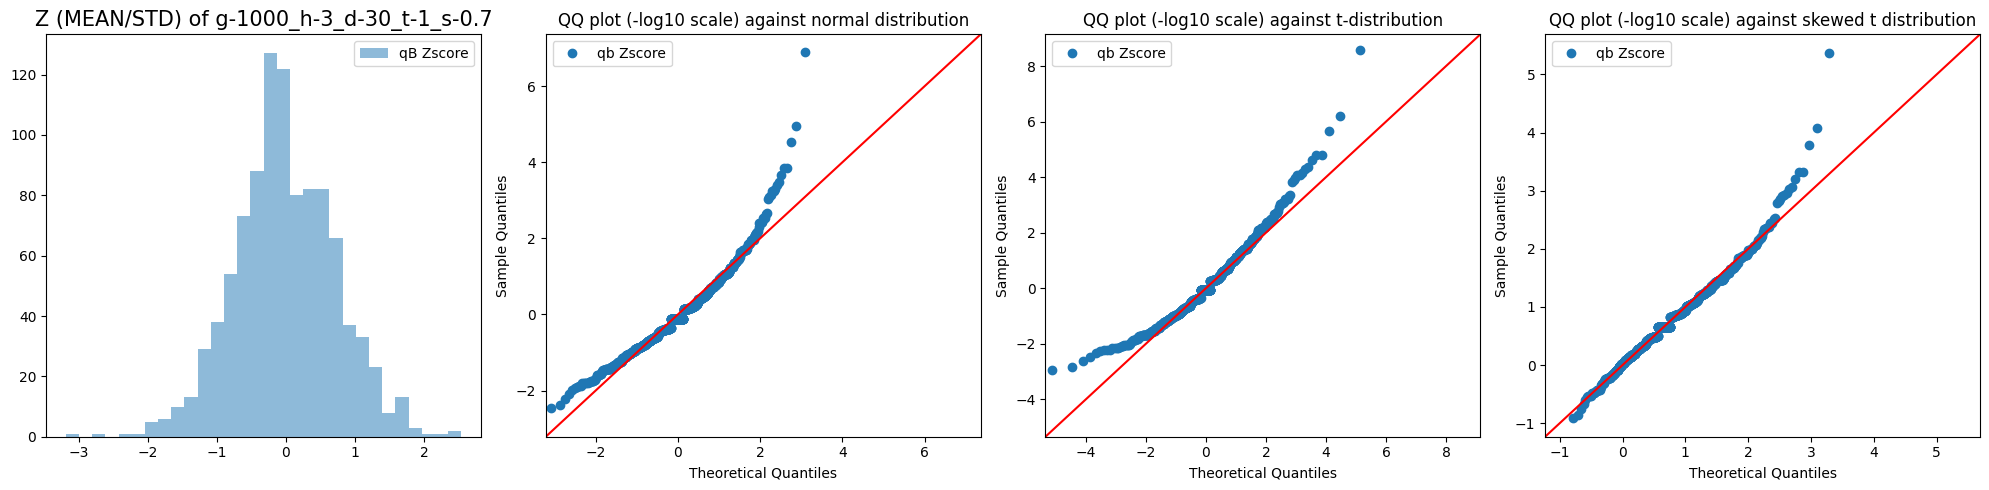

In [11]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
qb_directory="withcache_trap10K"
theta=1

plot_QQ_log10(qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withcache
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


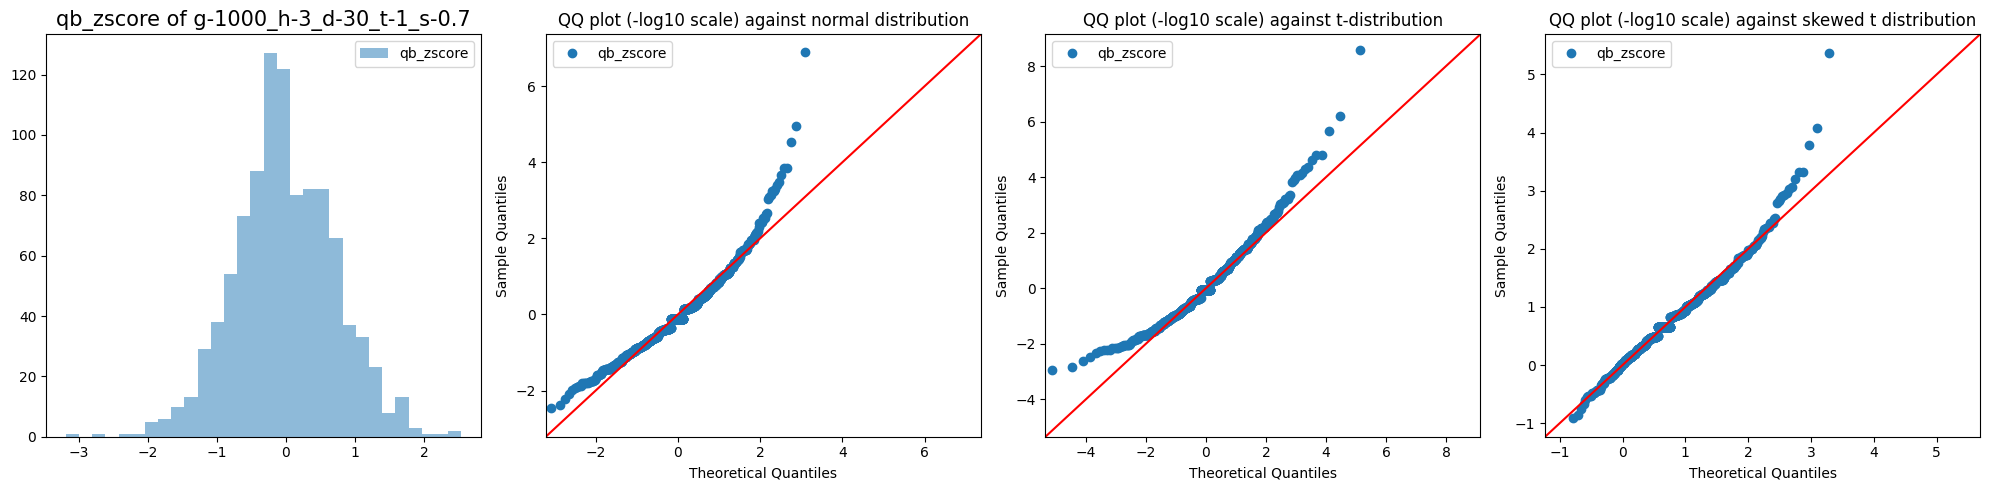

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withcache_withnull
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


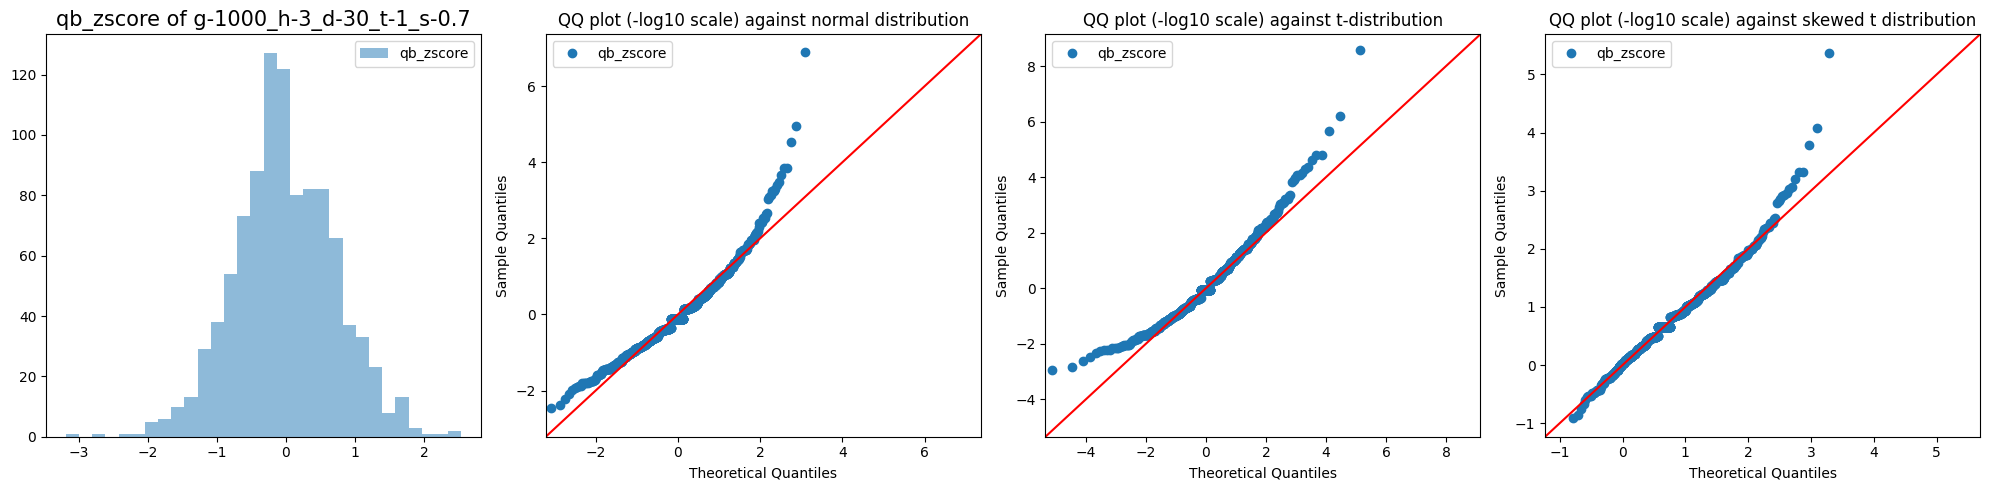

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withoutcache
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


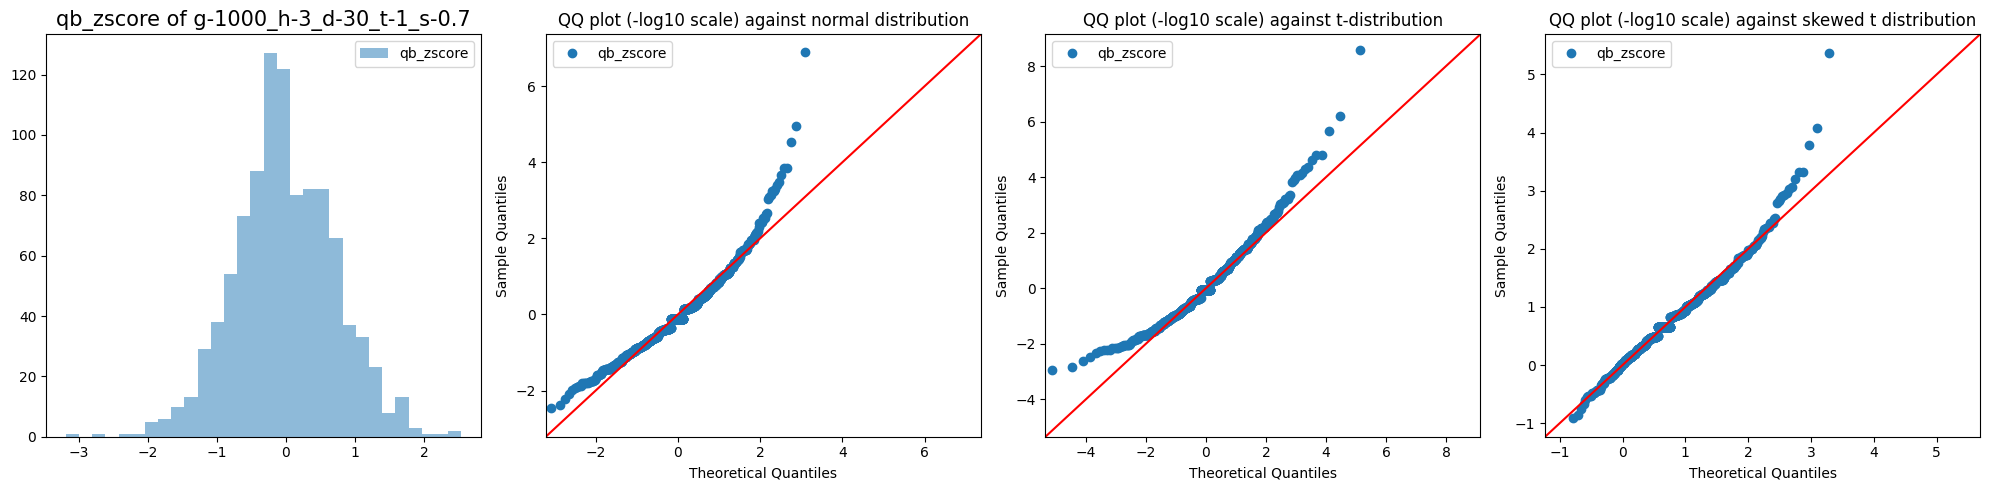

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withoutcache_withnull
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


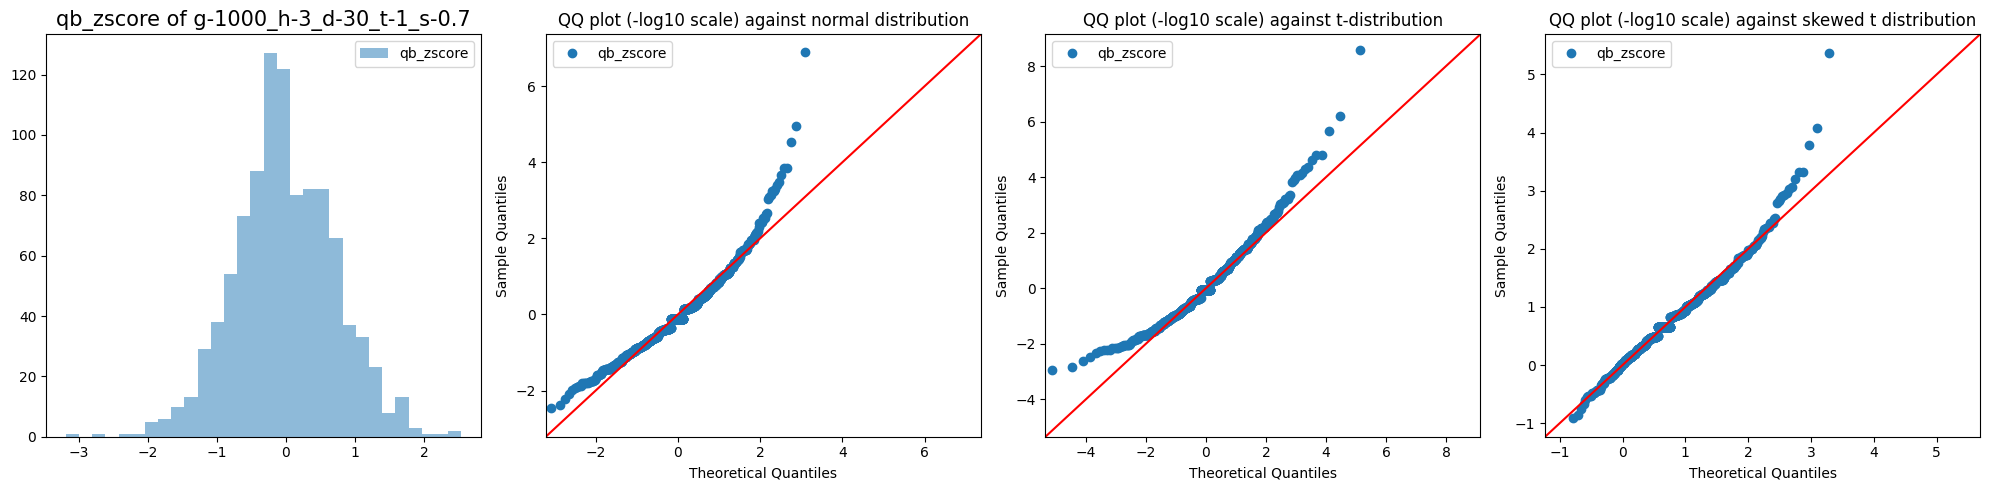

In [7]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
qb_directory="withoutcache"
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
label="qb_zscore"

qb_directories = [f'{path}/withcache',  f'{path}/withcache_withnull', f'{path}/withoutcache', f'{path}/withoutcache_withnull']

for qb_directory in qb_directories:
    print(qb_directory)
    plot_QQ_log10(label,qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withcache
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


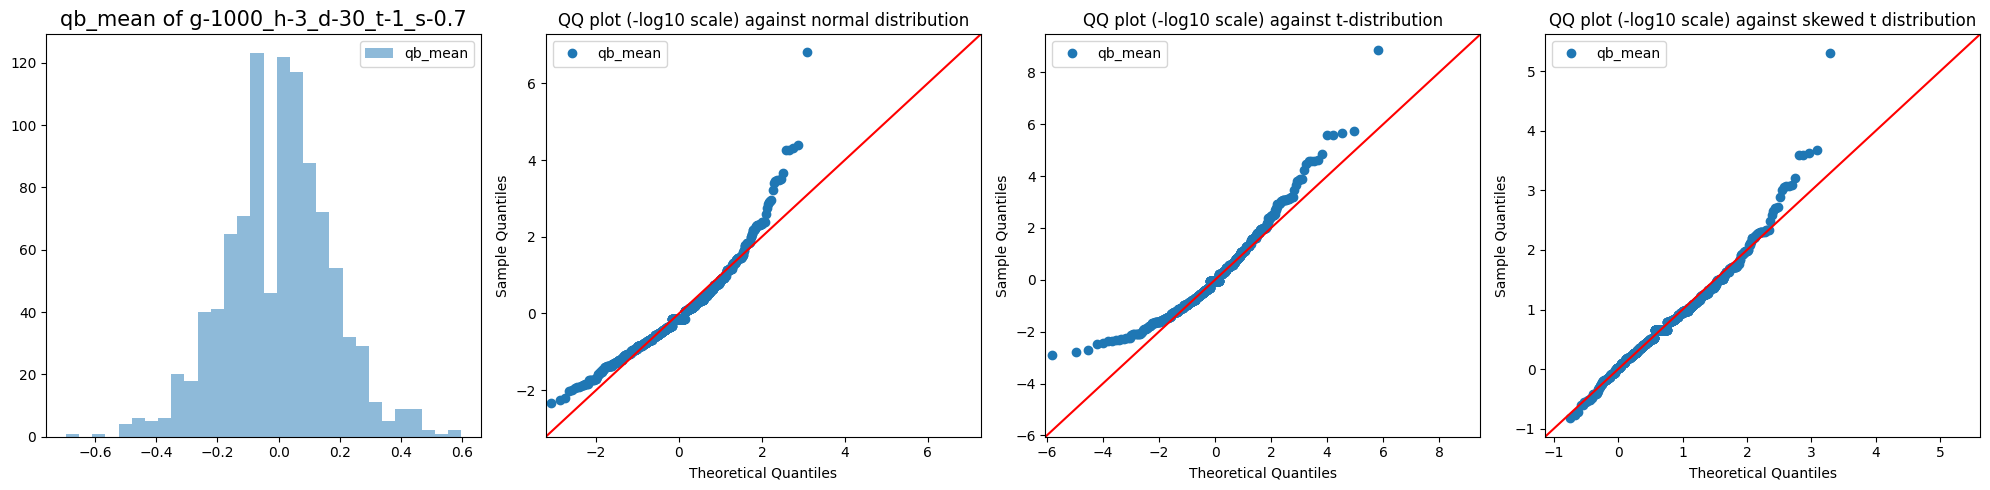

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withcache_trap10K
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


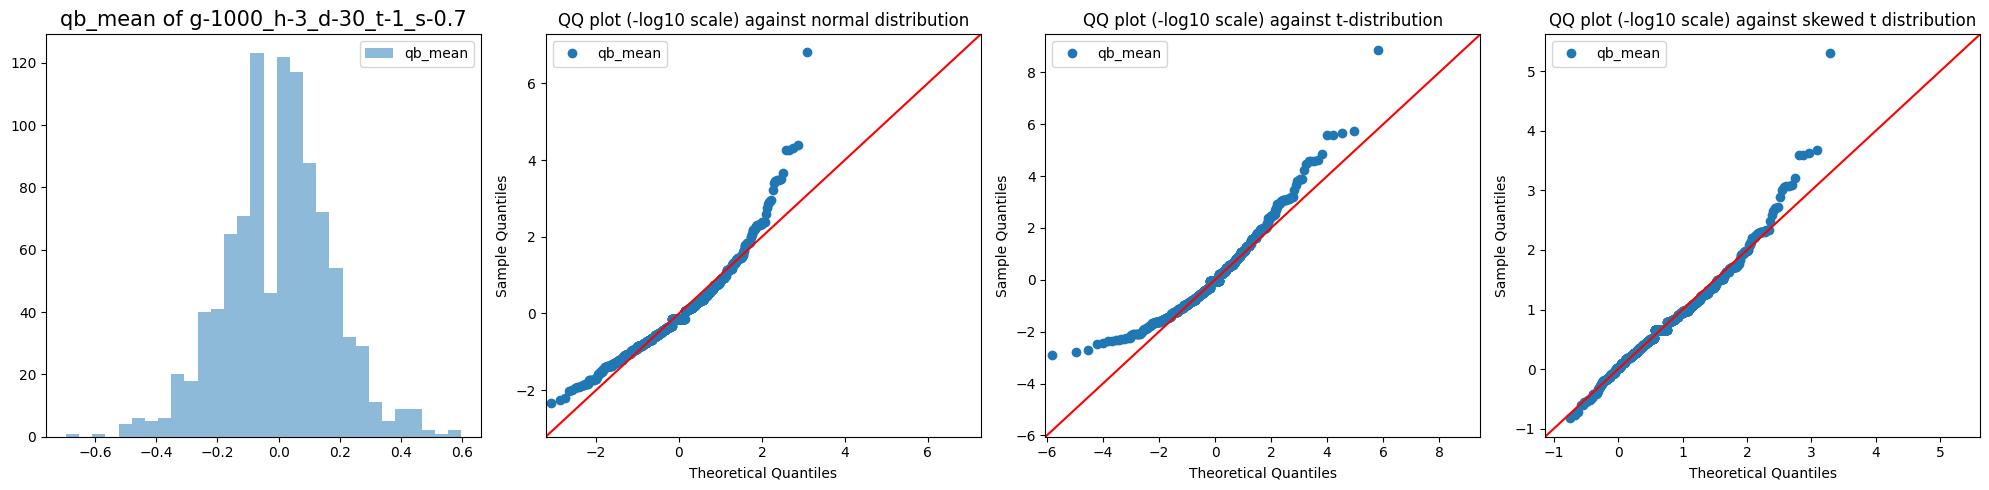

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withcache_trap100K
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


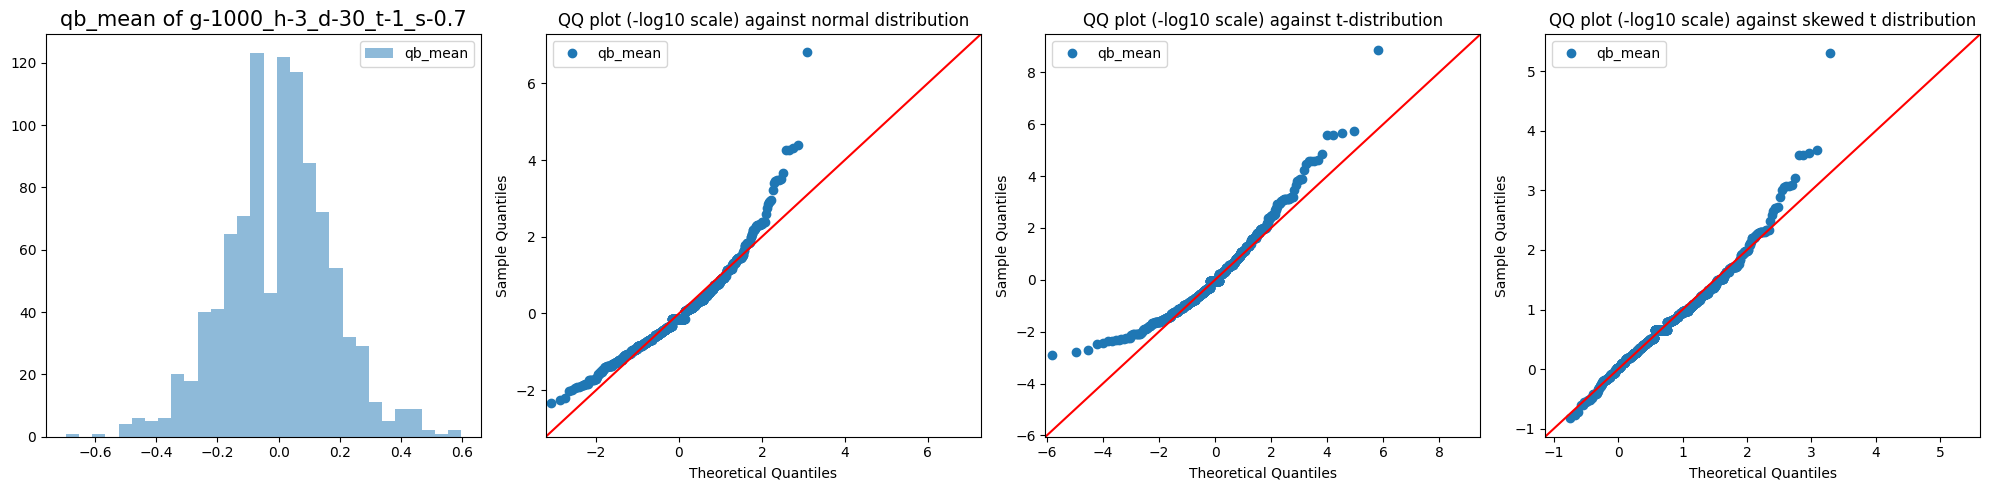

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withoutcache
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


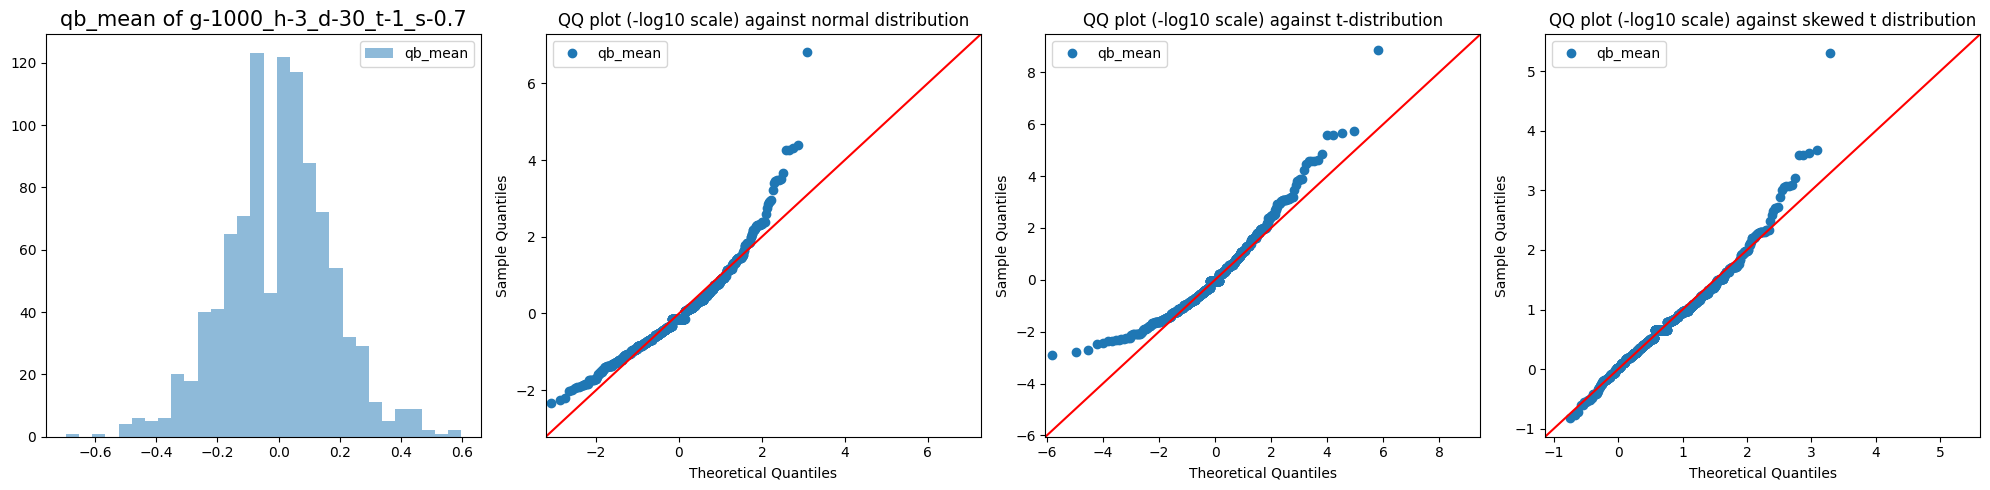

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withoutcache_trap10K
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


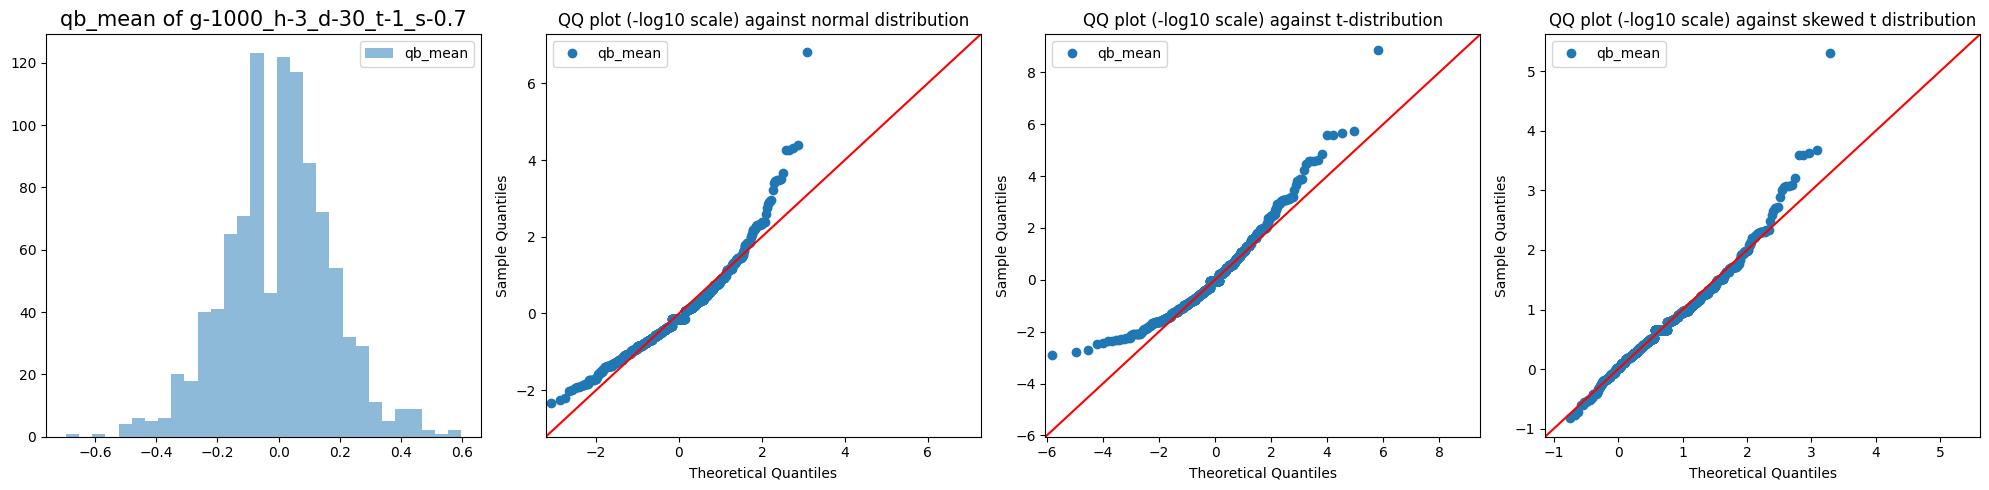

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/withoutcache_trap100K
>>>> alpha/beta parameter at 8.789625


/tmp/ipykernel_2520075/729081661.py:34: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:16: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)
/tmp/ipykernel_2520075/729081661.py:52: RuntimeWarning: divide by zero encountered in log10
  transformed_data = -np.log10(shifted_data)


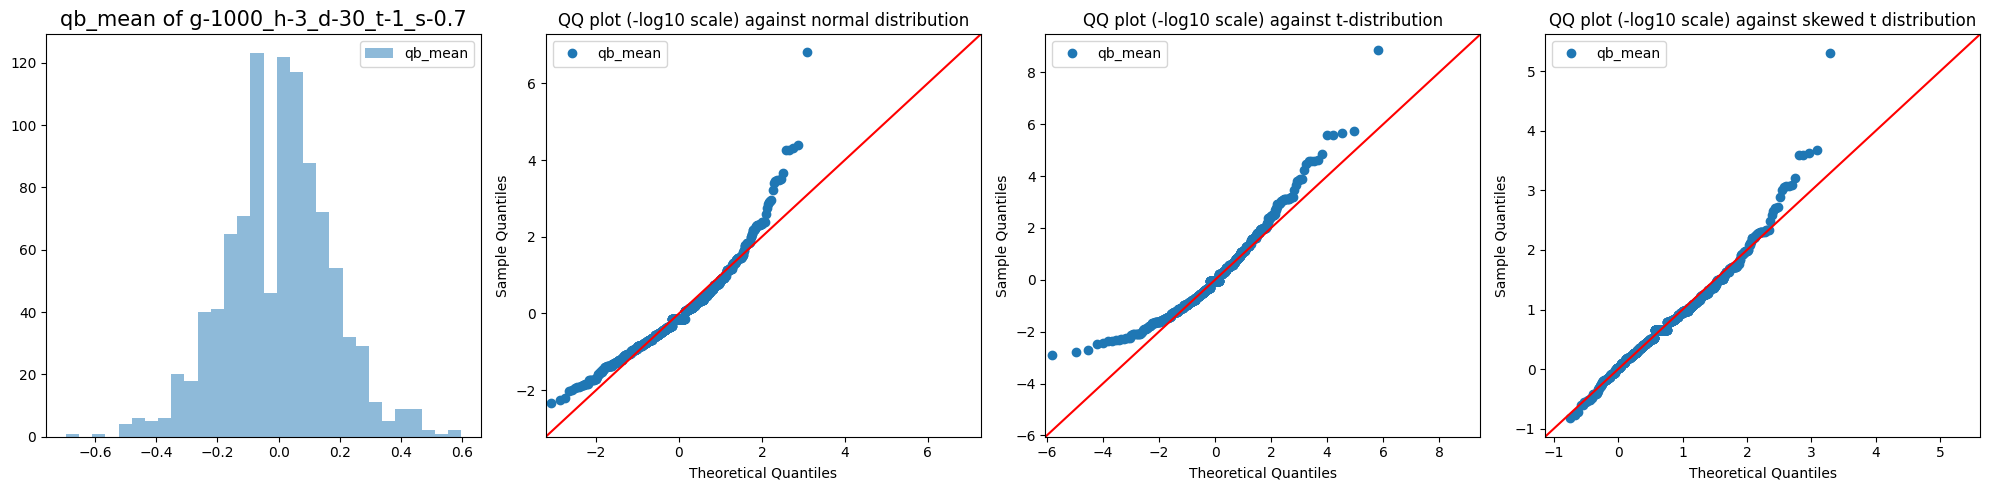

In [10]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
qb_directory="withoutcache"
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
label="qb_mean"

qb_directories = [f'{path}/withcache',  f'{path}/withcache_trap10K', f'{path}/withcache_trap100K', f'{path}/withoutcache',  f'{path}/withoutcache_trap10K', f'{path}/withoutcache_trap100K']

for qb_directory in qb_directories:
    print(qb_directory)
    plot_QQ_log10(label,qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


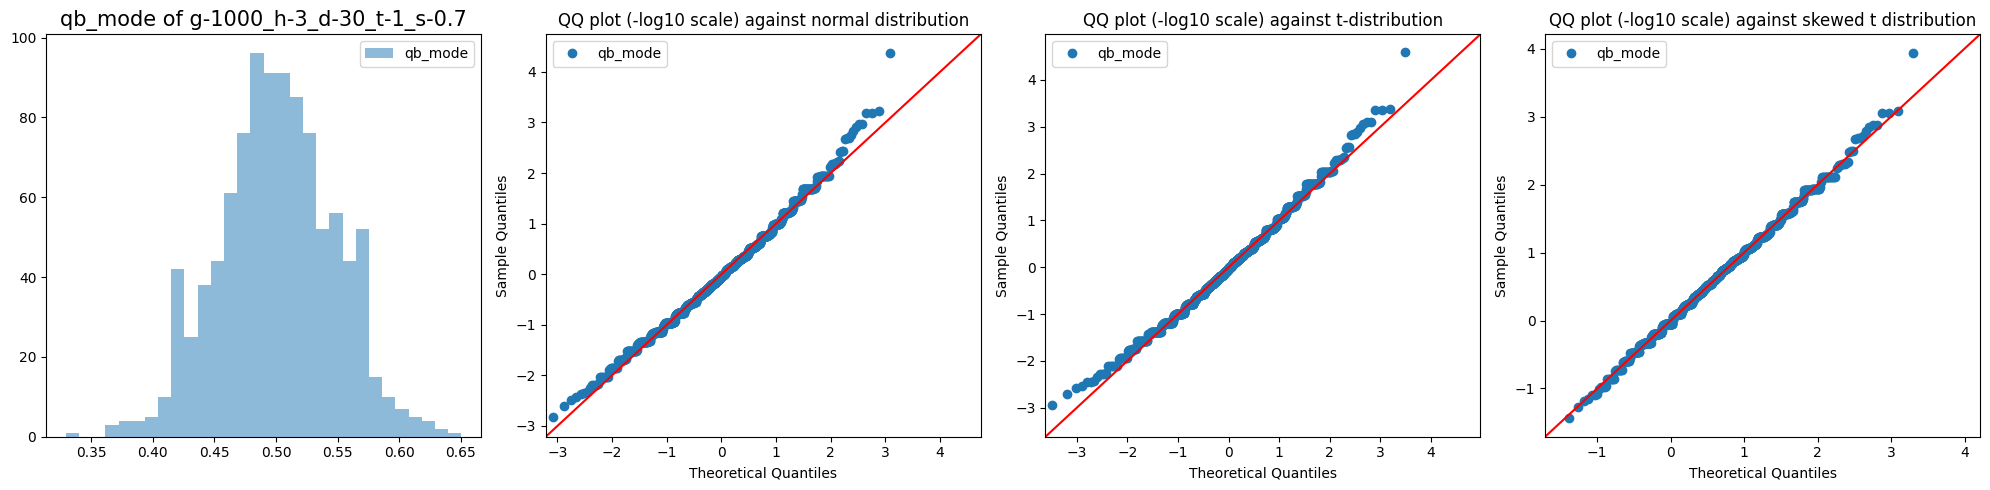

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


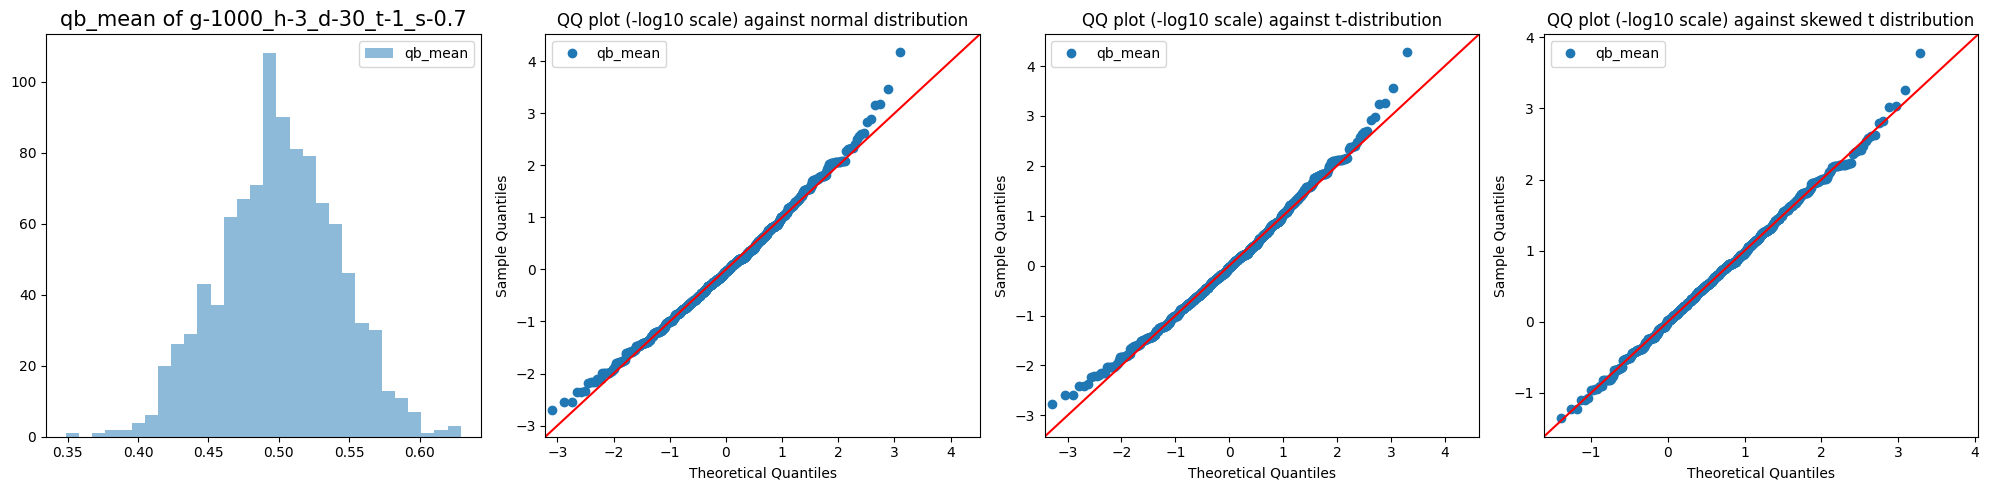

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


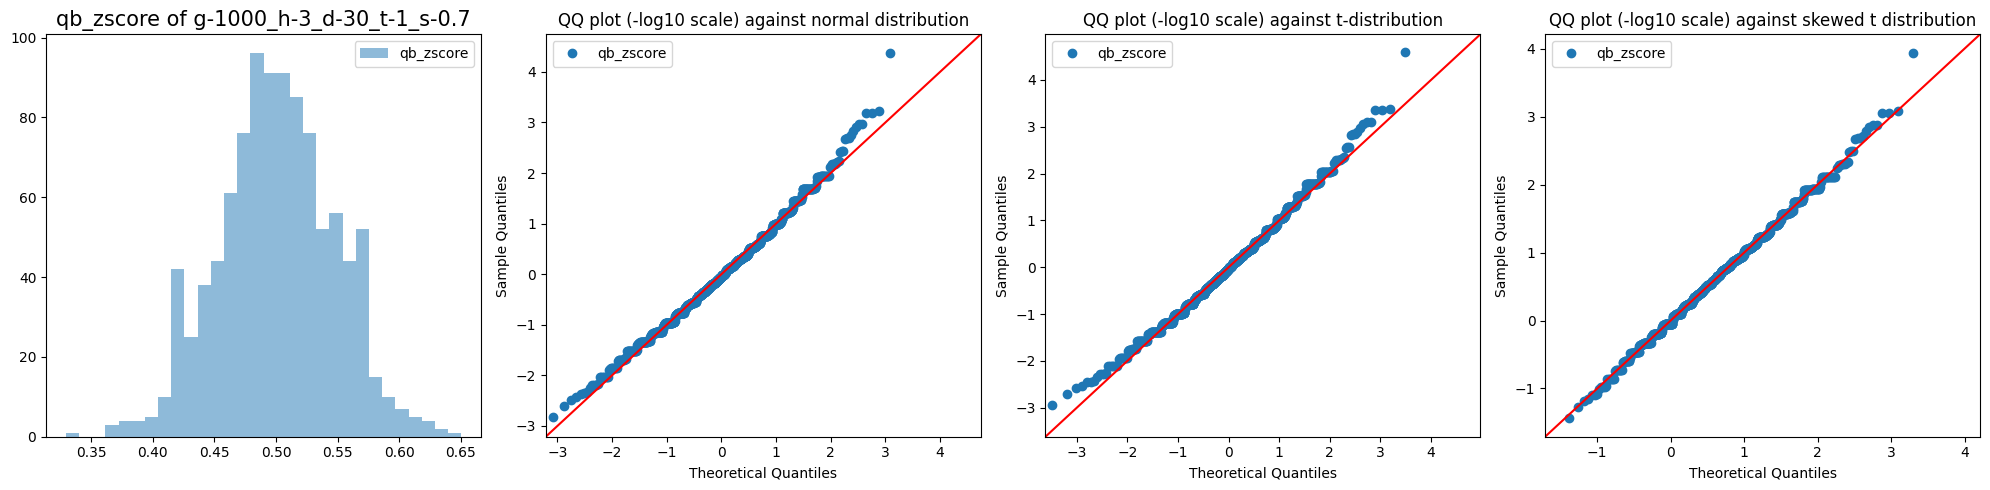

In [7]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
labels=["qb_mode","qb_mean","qb_zscore"]
qb_directory=path
for label in labels:
    
    plot_QQ_log10(label,qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


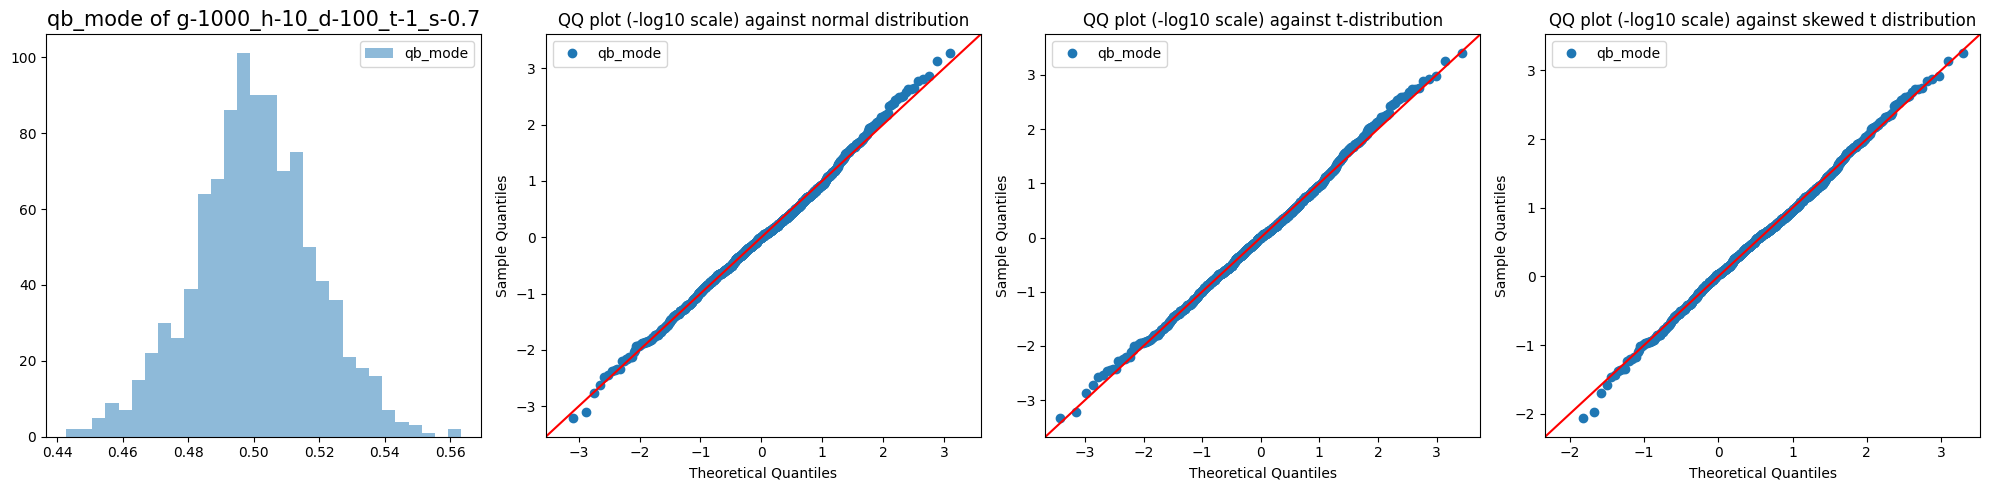

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


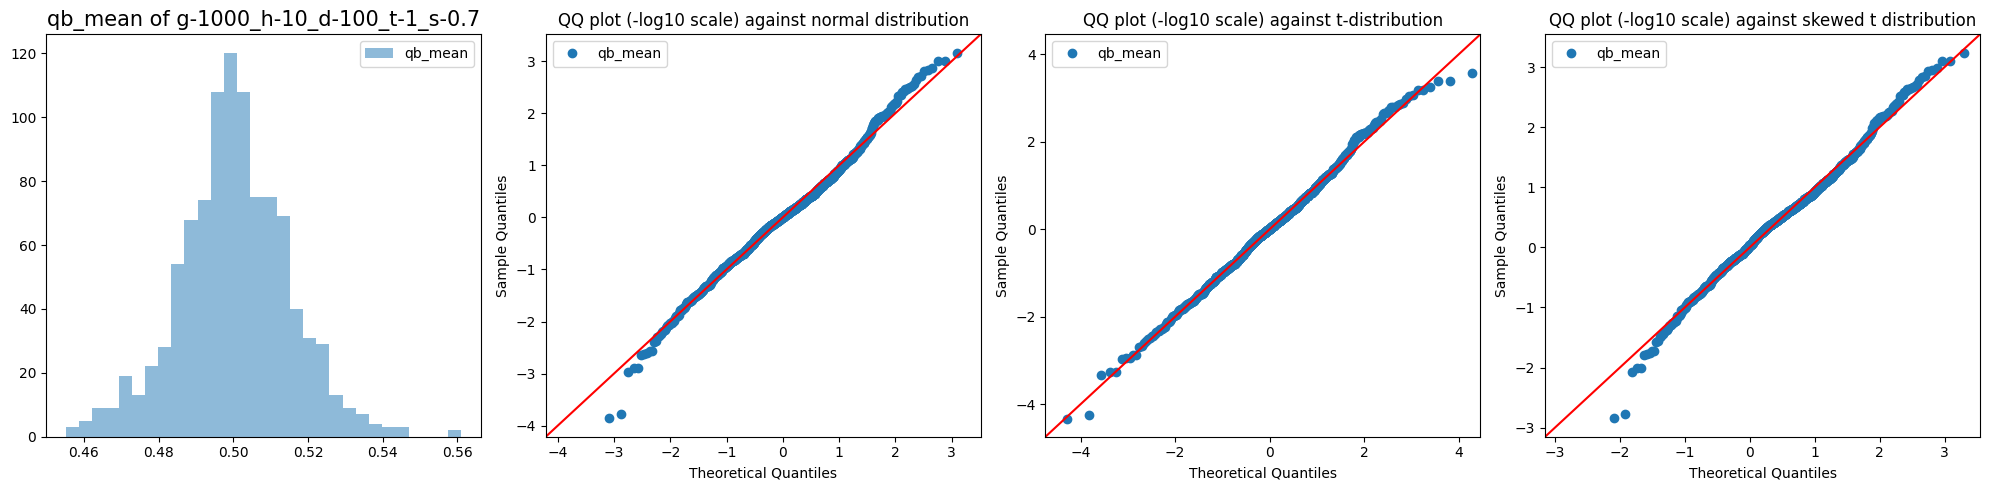

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


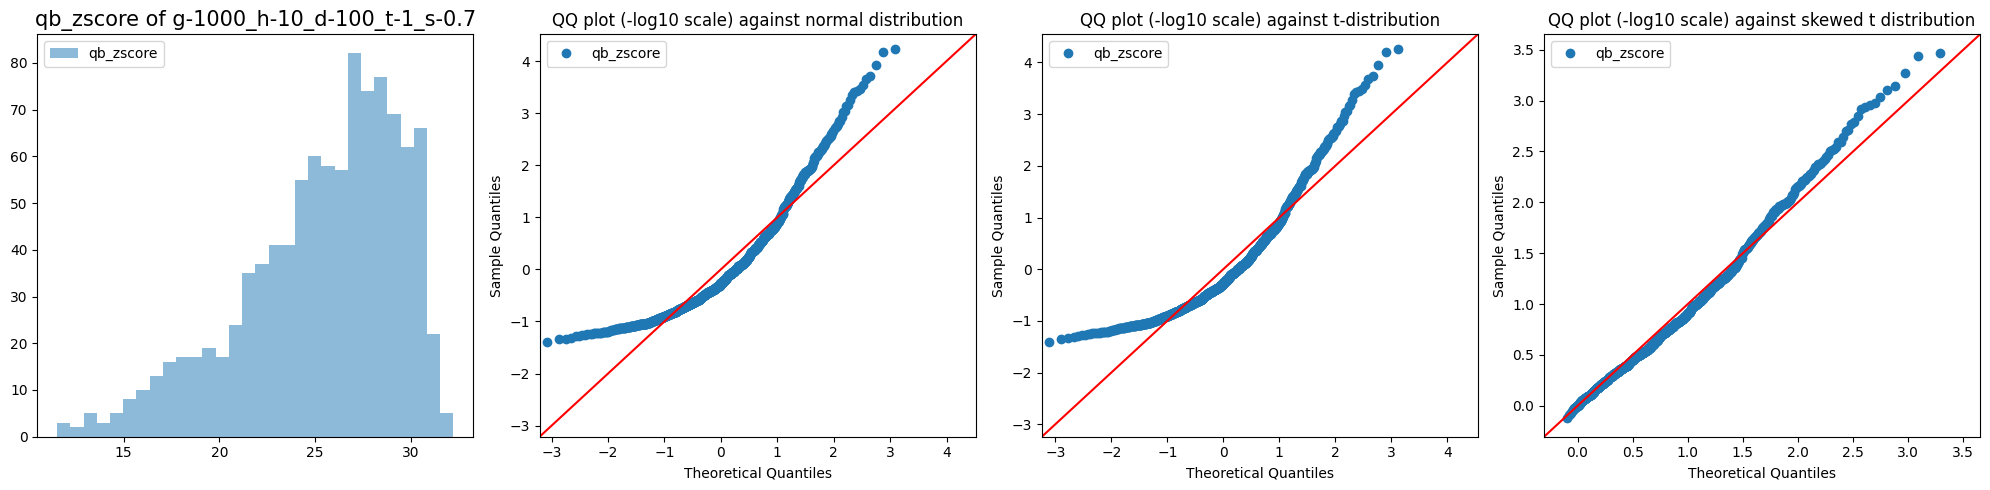

In [34]:
n_gene=1000
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
labels=["qb_mode","qb_mean","qb_zscore"]
qb_directory=path
for label in labels:
    
    plot_QQ_log10(label,qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


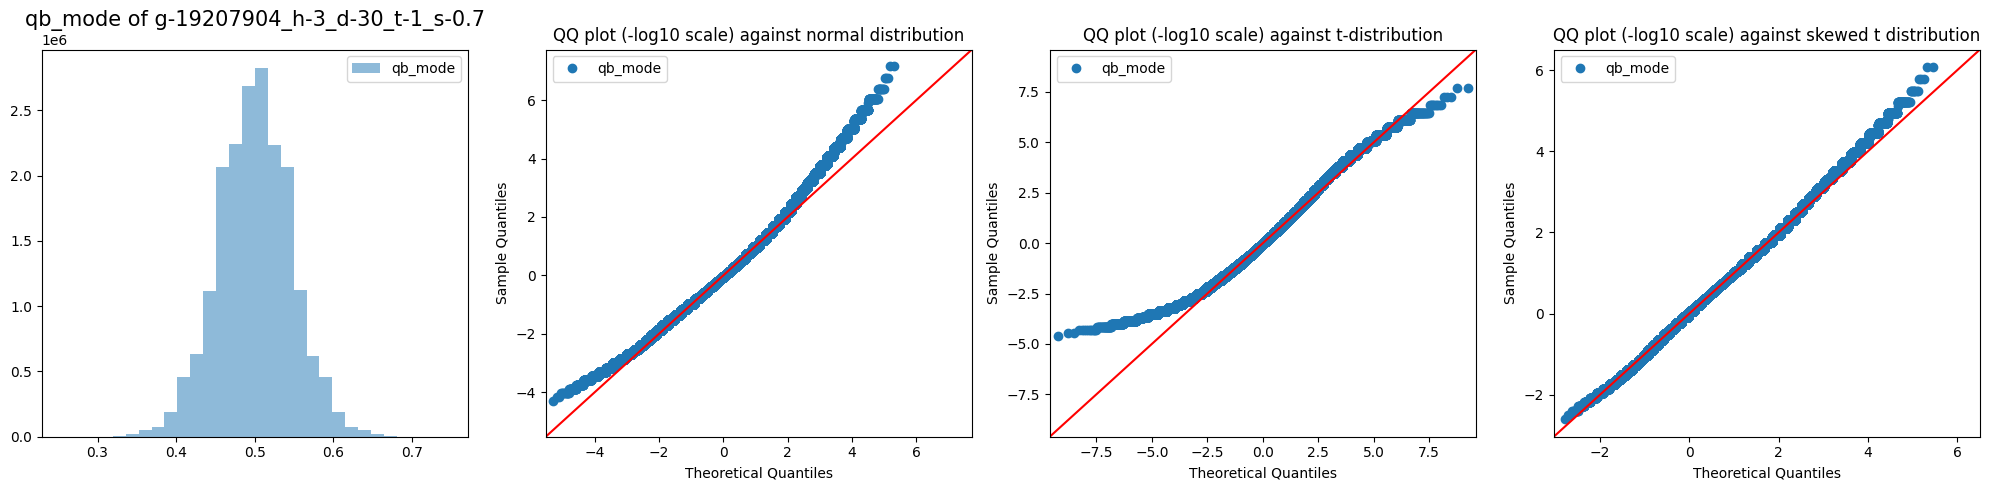

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


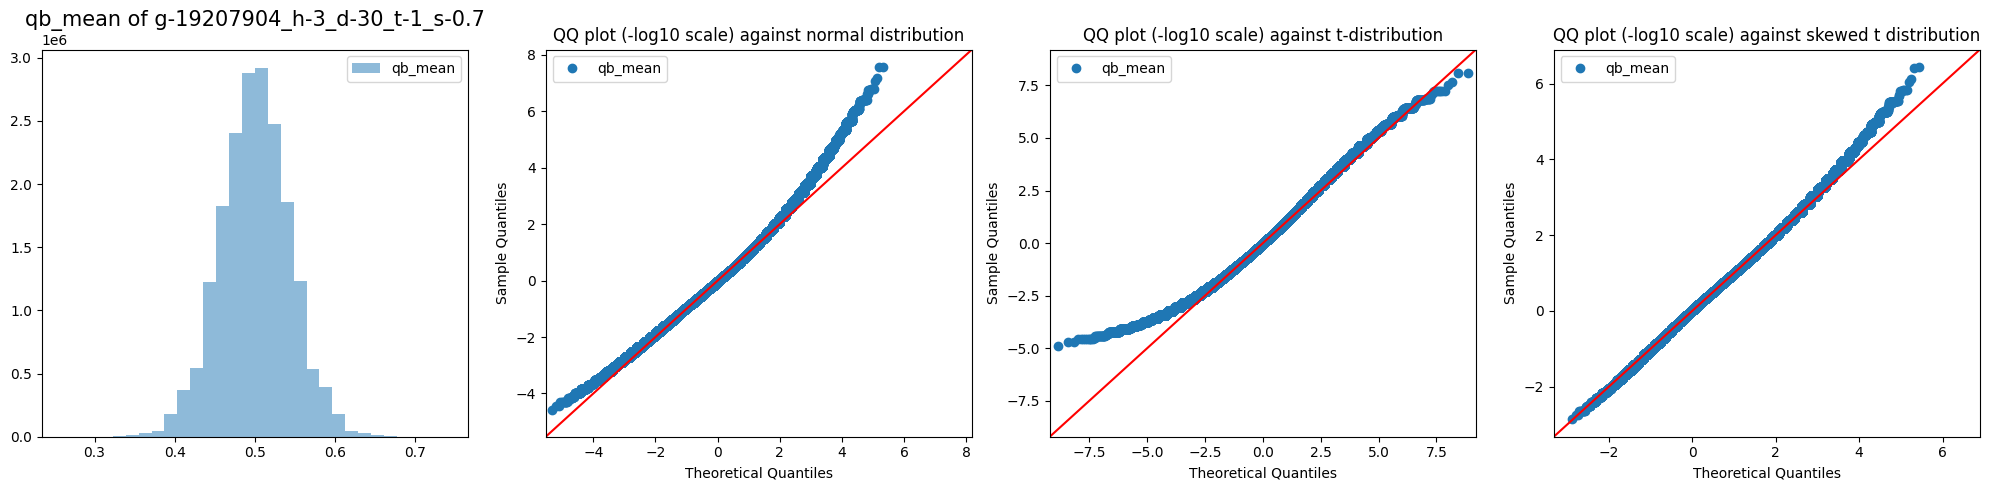

/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


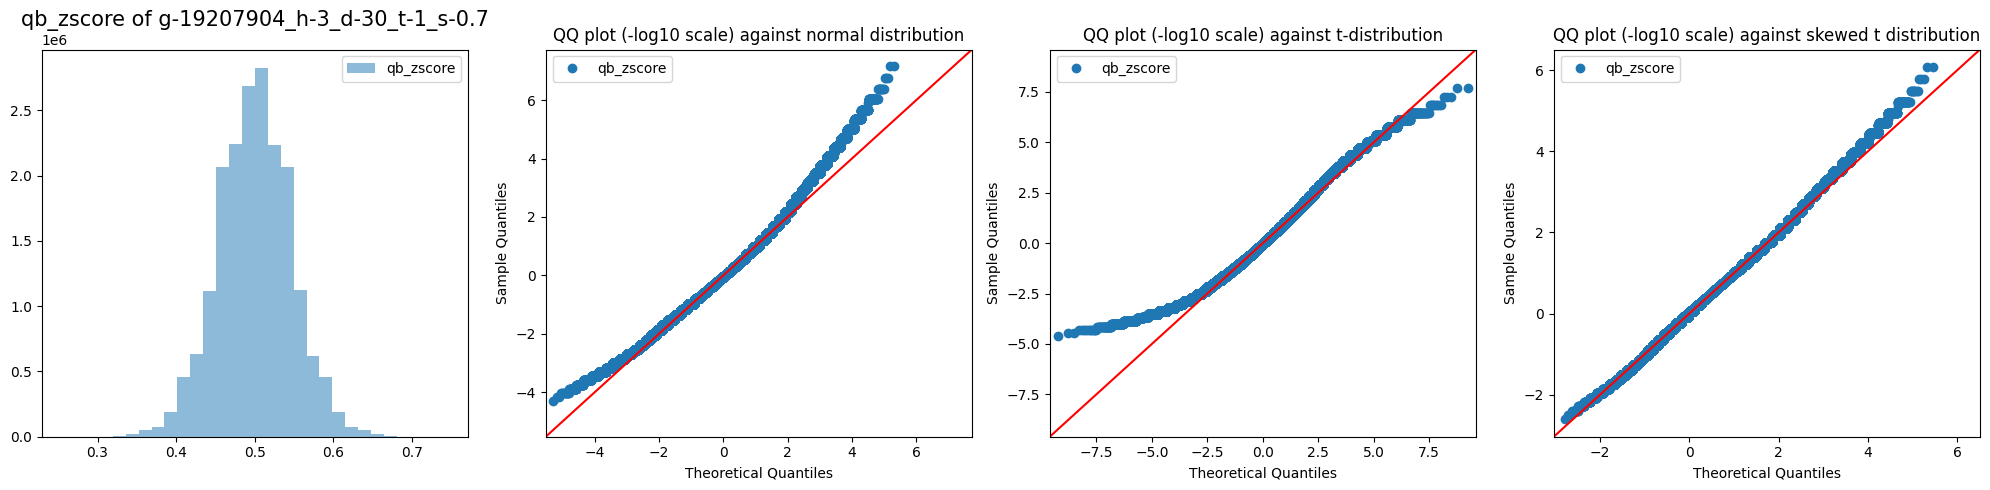

In [8]:
n_gene=19207904
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
labels=["qb_mode","qb_mean","qb_zscore"]
qb_directory=path
for label in labels:
    
    plot_QQ_log10(label,qb_directory,n_gene,n_hets,n_depth,theta,alpha_beta,sigma)

In [137]:
def plot_mean_mode(label,path_qb,n_gene, n_hets, n_depth, theta, alpha_beta, sigma):
    print(path_qb)
    NEG = f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    qb = get_z(path_qb,n_gene,n_hets, n_depth, theta, alpha_beta, sigma)
    #BEASTIE_zscore = calculate_posterior_value("z", BEASTIE)
    mean = pd.to_numeric(qb["qb_mean"], errors='coerce').dropna().tolist()
    mode = pd.to_numeric(qb["qb_mode"], errors='coerce').dropna().tolist()

    # Plotting
    plt.scatter(mean,mode)
    # Assuming you want a line from the bottom left to the top right
    plt.plot([min(mode), max(mode)], [min(mode), max(mode)], color='red')  # Diagonal line
    plt.title("mean vs mode",fontsize=15)
    plt.legend()
    plt.xlabel("untransformed mean")
    plt.ylabel("untransformed mode")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error
>>>> alpha/beta parameter at 8.789625
/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error


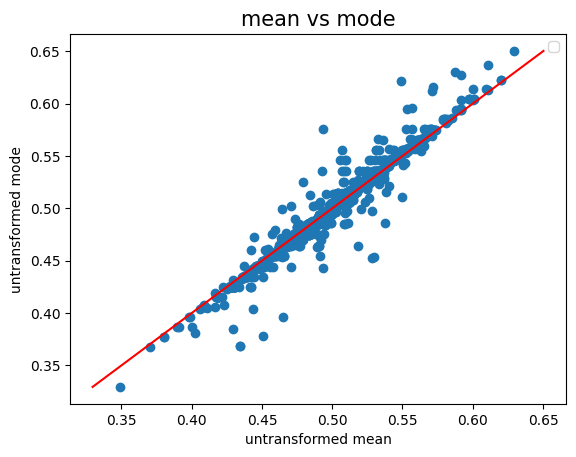

In [138]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"

plot_mean_mode(label,path,n_gene, n_hets, n_depth, theta, alpha_beta, sigma)

In [139]:
GIAB=pd.read_csv(f"/home/zack/code/QuickBEAST/NA12878_dist.tsv",delimiter="\t",header=None)
GIAB

,0,1,2,3,4,5,6,7,8,9,...,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
0,ENSG00000187583.6,0,0,0.000999,2.722400e-25,0.001998,2.379050e-22,0.002997,1.243850e-20,0.003996,...,0.996004,2.367990e-20,0.997003,1.075040e-21,0.998002,1.369740e-23,0.999001,7.827490e-27,1,0
1,ENSG00000188290.6,0,0,0.000999,3.382600e-30,0.001998,1.187030e-26,0.002997,1.401810e-24,0.003996,...,0.996004,6.393790e-16,0.997003,5.160470e-17,0.998002,1.479370e-18,0.999001,3.381800e-21,1,0
2,ENSG00000187608.5,0,0,0.000999,0.000000e+00,0.001998,0.000000e+00,0.002997,0.000000e+00,0.003996,...,0.996004,0.000000e+00,0.997003,0.000000e+00,0.998002,0.000000e+00,0.999001,0.000000e+00,1,0
3,ENSG00000188157.9,0,0,0.000999,0.000000e+00,0.001998,0.000000e+00,0.002997,0.000000e+00,0.003996,...,0.996004,0.000000e+00,0.997003,0.000000e+00,0.998002,0.000000e+00,0.999001,0.000000e+00,1,0
4,ENSG00000237330.2,0,0,0.000999,6.440210e-22,0.001998,2.822190e-19,0.002997,9.865140e-18,0.003996,...,0.996004,1.605080e-15,0.997003,1.725350e-16,0.998002,7.410980e-18,0.999001,3.384770e-20,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,ENSG00000198113.2,0,0,0.000999,0.000000e+00,0.001998,0.000000e+00,0.002997,0.000000e+00,0.003996,...,0.996004,0.000000e+00,0.997003,0.000000e+00,0.998002,0.000000e+00,0.999001,0.000000e+00,1,0
7632,ENSG00000187609.11,0,0,0.000999,0.000000e+00,0.001998,0.000000e+00,0.002997,0.000000e+00,0.003996,...,0.996004,0.000000e+00,0.997003,0.000000e+00,0.998002,0.000000e+00,0.999001,0.000000e+00,1,0
7633,ENSG00000165802.15,0,0,0.000999,0.000000e+00,0.001998,4.203900e-45,0.002997,1.115710e-41,0.003996,...,0.996004,1.954050e-22,0.997003,5.030100e-24,0.998002,2.871430e-26,0.999001,4.134940e-30,1,0
7634,ENSG00000197070.9,0,0,0.000999,0.000000e+00,0.001998,0.000000e+00,0.002997,0.000000e+00,0.003996,...,0.996004,0.000000e+00,0.997003,0.000000e+00,0.998002,0.000000e+00,0.999001,0.000000e+00,1,0


In [30]:
example = GIAB.iloc[0]
row = example

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [66]:
random_row = GIAB.sample(n=1).iloc[0]
y_values = random_row[2::2].values
stats.mode(y_values)

TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

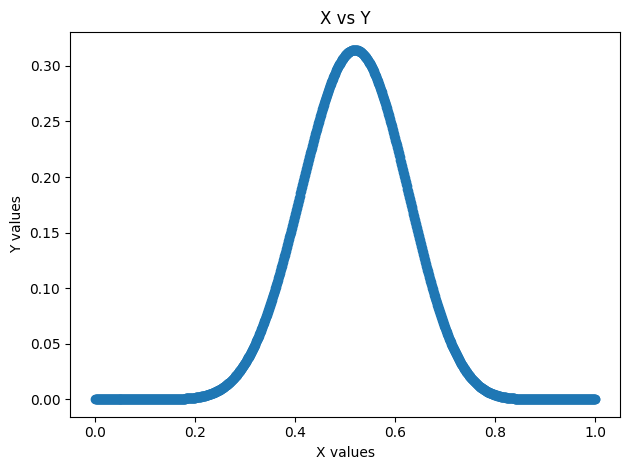

Mean of y: 0.08107736850504453
Mode of y: 0.0


In [38]:
GIAB=pd.read_csv(f"/home/zack/code/QuickBEAST/NA12878_dist.tsv",delimiter="\t",header=None)

In [7]:


def visualize_gene_data(input_file_name):
    # Read the TSV file
    df = pd.read_csv(input_file_name, sep='\t')
    
    # Randomly pick a row (gene)
    random_row = df.sample(n=1).iloc[0]
    gene_id = random_row[0]
    
    # Extract x and y values
    x_values = random_row[1::2].values
    y_values = random_row[2::2].values

    # Convert y_values to numeric, coercing errors to NaN
    y_values_numeric = pd.to_numeric(y_values, errors='coerce')

    # Filter out NaN values
    filtered_y_values = y_values_numeric[~np.isnan(y_values_numeric)]

    # Calculate mode
    mode_result = stats.mode(filtered_y_values)

    # Now calculate the mode using the numeric values
    # Check if mode_result.mode is a scalar or an array
    if np.isscalar(mode_result.mode):
        y_mode = mode_result.mode
    else:
        y_mode = mode_result.mode[0]
    # Calculate mean
    y_mean = np.nanmean(y_values_numeric)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot histogram of Y values
    ax[0].hist(y_values, bins=100, color='blue', edgecolor='black')
    ax[0].axvline(y_mean, color='red', linestyle='dashed', linewidth=4, label=f'Mean: {y_mean}')
    ax[0].axvline(y_mode, color='green', linestyle='dashed', linewidth=4, label=f'Mode: {y_mode:.5f}')
    ax[0].set_title(f'Histogram of Density values for {gene_id}')
    ax[0].set_xlabel('Density value')
    ax[0].set_ylabel('Count')
    ax[0].legend()
    # Scatter plot of X vs Y values
    ax[1].scatter(x_values, y_values, color='red')
    ax[1].set_title('Scatter Plot of p-value vs Density values')
    ax[1].set_xlabel('P value')
    ax[1].set_ylabel('Density value')


    plt.tight_layout()
    plt.show()


def calculate_mean_mode_relationship(input_file_name):
    # Read the TSV file without headers
    df = pd.read_csv(input_file_name, sep='\t', header=None)
    
    # Assuming the first column is geneID, we will drop it to calculate the mean and mode
    y_values = df.drop(0, axis=1).iloc[:, 1::2]
    
    # Calculate the mean and mode for the y-values
    means = y_values.mean(axis=1)
    modes = y_values.mode(axis=1)[0]  # Taking the first mode if there are multiple

    # Create a scatter plot to explore the relationship between mean and mode
    plt.scatter(means, modes, alpha=0.6, edgecolors='w', s=80)
    plt.title('Mean vs Mode of Density Values')
    plt.xlabel('Mean of Density Values')
    plt.ylabel('Mode of Density Values')
    plt.grid(True)
    plt.show()

    return means, modes


/tmp/ipykernel_2900224/2995240970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


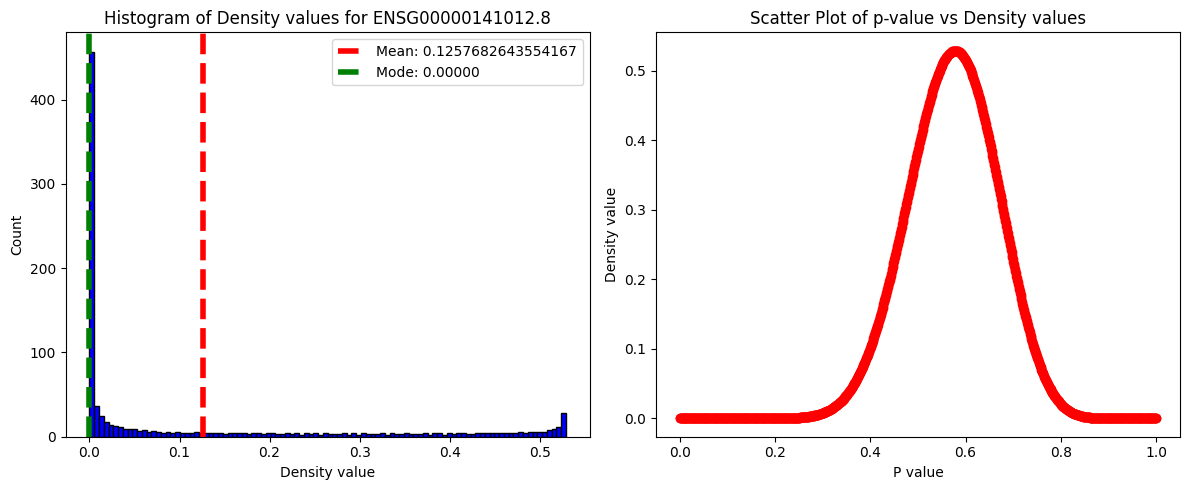

In [44]:
GIAB="/home/zack/code/QuickBEAST/NA12878_dist.tsv"
input_file_name=GIAB
visualize_gene_data(input_file_name)

/tmp/ipykernel_1862706/2995240970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


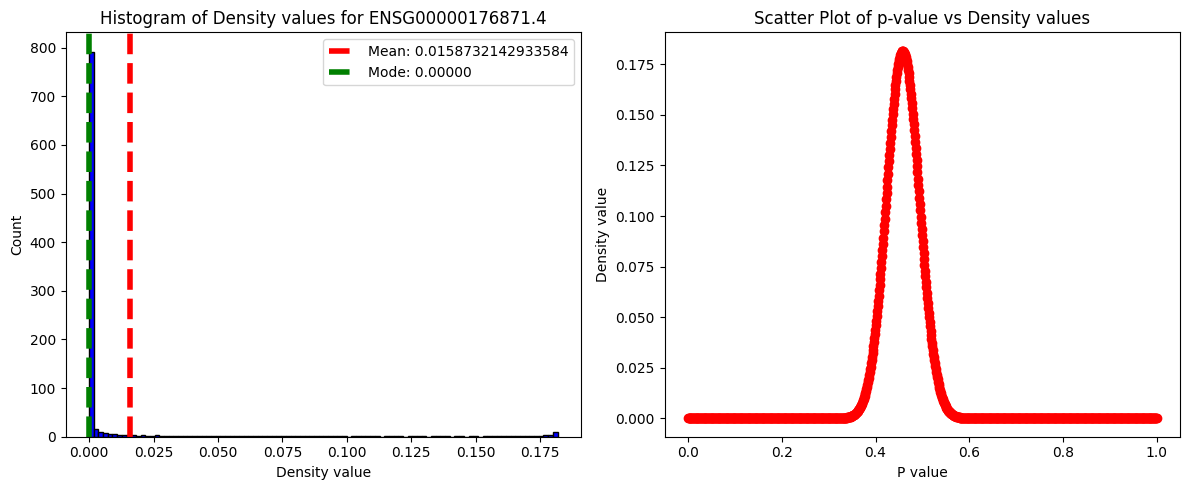

In [121]:
GIAB="/home/zack/code/QuickBEAST/NA12878_dist.tsv"
input_file_name=GIAB
visualize_gene_data(input_file_name)

/tmp/ipykernel_1862706/2995240970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


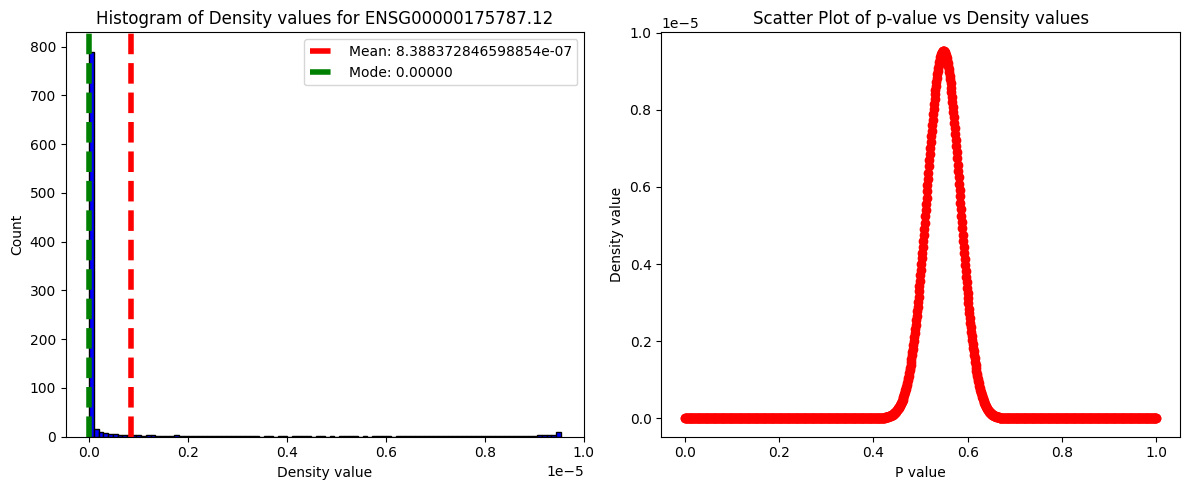

In [122]:
GIAB="/home/zack/code/QuickBEAST/NA12878_dist.tsv"
input_file_name=GIAB
visualize_gene_data(input_file_name)

/tmp/ipykernel_1862706/4162162906.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


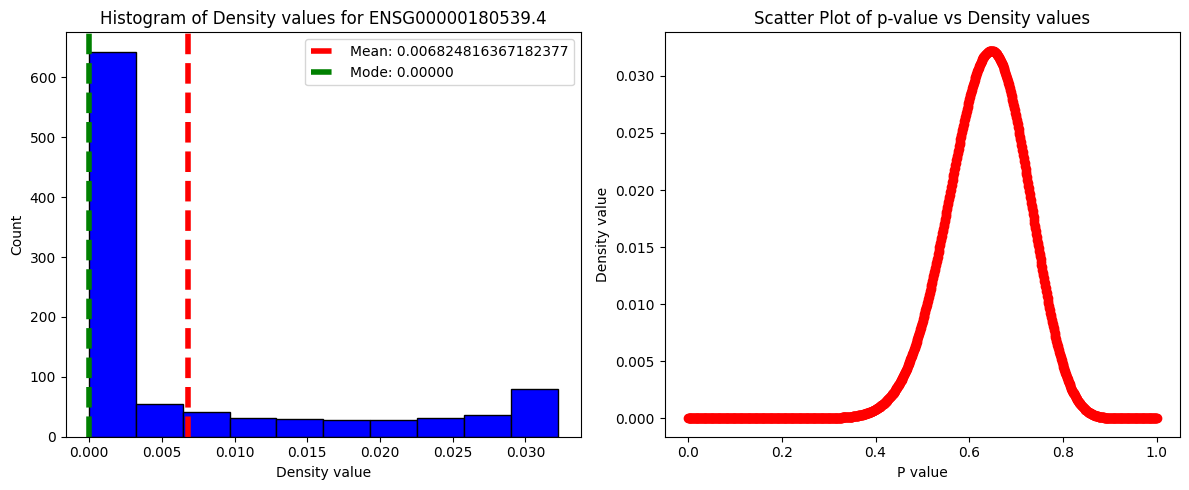

In [111]:
GIAB="/home/zack/code/QuickBEAST/NA12878_dist.tsv"
input_file_name=GIAB
visualize_gene_data(input_file_name)

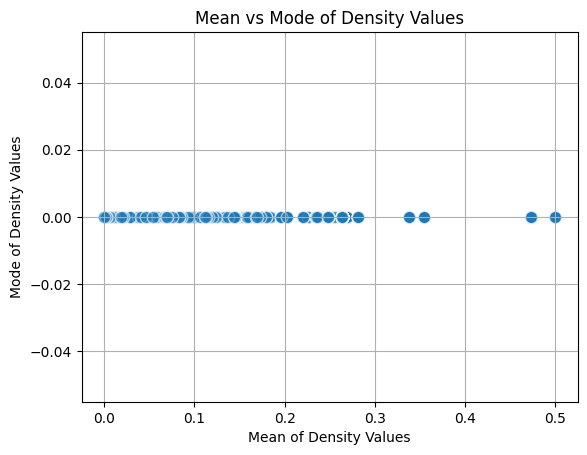

(0       8.107737e-02
 1       1.692229e-01
 2       1.011842e-03
 3       2.630509e-14
 4       1.194967e-01
             ...     
 7631    1.683864e-03
 7632    5.411370e-02
 7633    6.962611e-02
 7634    2.299768e-03
 7635    1.160397e-07
 Length: 7636, dtype: float64,
 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 7631    0.0
 7632    0.0
 7633    0.0
 7634    0.0
 7635    0.0
 Name: 0, Length: 7636, dtype: float64)

In [112]:
calculate_mean_mode_relationship(input_file_name=GIAB)

In [45]:
null_sample = "/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/g-1000_h-3_d-30_t-1.txt.dist"

/tmp/ipykernel_2900224/2995240970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


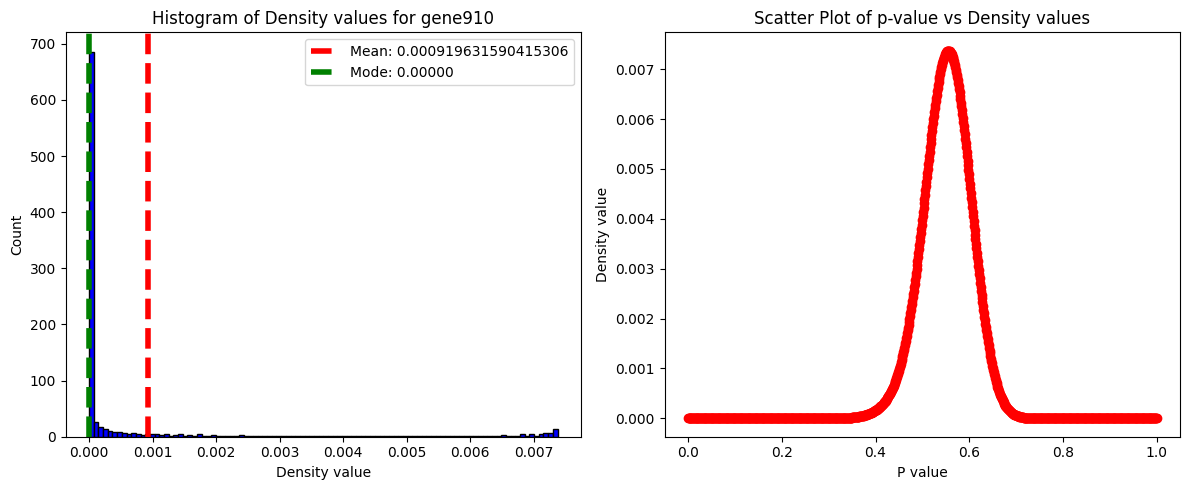

In [83]:
input_file_name=null_sample
visualize_gene_data(input_file_name)

/tmp/ipykernel_2900224/2995240970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_id = random_row[0]


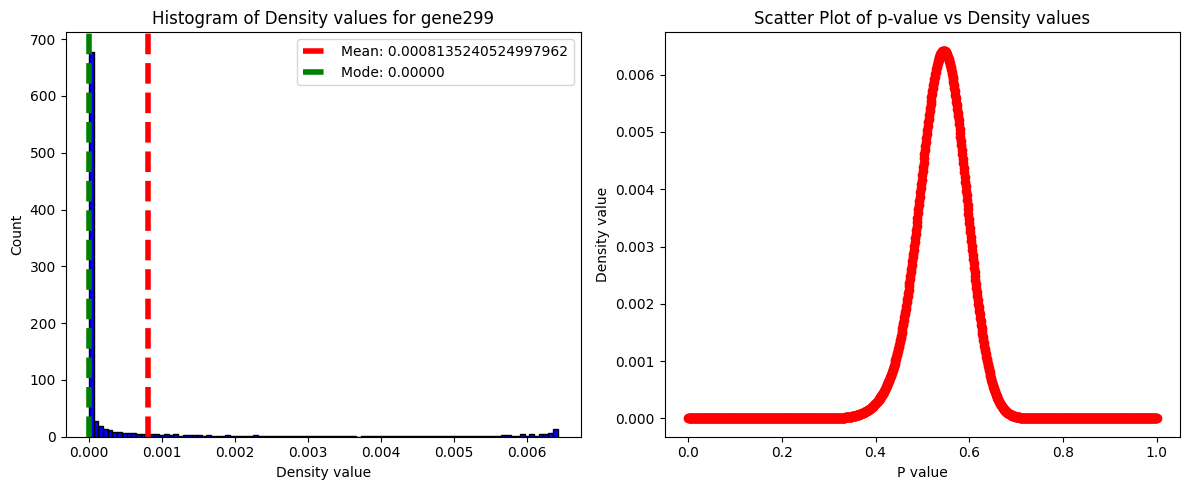

In [84]:
input_file_name=null_sample
visualize_gene_data(input_file_name)

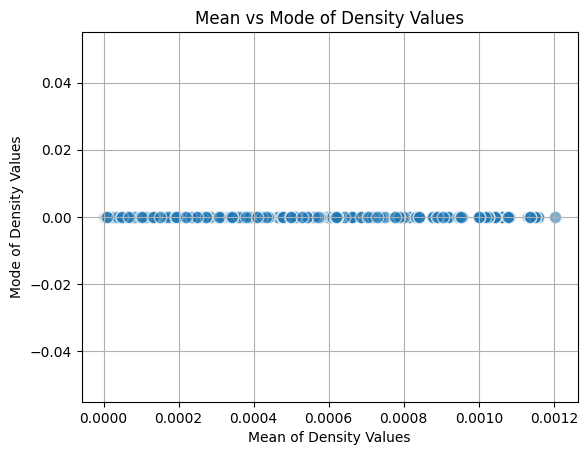

(0      0.001024
 1      0.000576
 2      0.000627
 3      0.000408
 4      0.000794
          ...   
 995    0.000841
 996    0.000904
 997    0.000620
 998    0.000529
 999    0.000730
 Length: 1000, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 995    0.0
 996    0.0
 997    0.0
 998    0.0
 999    0.0
 Name: 0, Length: 1000, dtype: float64)

In [119]:
calculate_mean_mode_relationship(input_file_name=null_sample)

In [8]:

def visualize_gene_data(input_file_name):
    with open(input_file_name, 'r') as file:
        line = file.readline().strip()

    # Split the line into parts
    parts = line.split('\t')

    # Extract the gene ID
    gene_id = parts[0]

    # Extract Xs and Ys
    xs = parts[1::2]  # Take every second element starting from the first
    ys = parts[2::2]  # Take every second element starting from the second

    # Converting strings to floats for Xs and Ys if needed
    x_values = [float(x) for x in xs]
    y_values = [float(y) for y in ys]

    # Convert y_values to numeric, coercing errors to NaN
    y_values_numeric = pd.to_numeric(y_values, errors='coerce')

    # Filter out NaN values
    filtered_y_values = y_values_numeric[~np.isnan(y_values_numeric)]

    # Calculate mode
    mode_result = stats.mode(filtered_y_values)

    # Now calculate the mode using the numeric values
    # Check if mode_result.mode is a scalar or an array
    if np.isscalar(mode_result.mode):
        y_mode = mode_result.mode
    else:
        y_mode = mode_result.mode[0]
    # Calculate mean
    y_mean = np.nanmean(y_values_numeric)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot histogram of Y values
    ax[0].hist(y_values, bins=100, color='blue', edgecolor='black')
    ax[0].axvline(y_mode, color='blue', linestyle='dashed', linewidth=4, label=f'Mode: {y_mode:.5f}')
    ax[0].axvline(y_mean, color='green', linestyle='dashed', linewidth=4, label=f'Mean: {y_mean}')
    ax[0].set_title(f'Histogram of Density values for {gene_id}')
    ax[0].set_xlabel('Density value')
    ax[0].set_ylabel('Count')
    ax[0].legend()
    # Scatter plot of X vs Y values
    ax[1].scatter(x_values, y_values, color='red')
    ax[1].set_title(f'Posterior for {gene_id}')
    ax[1].set_xlabel('P value')
    ax[1].set_ylabel('Density value')


    plt.tight_layout()
    plt.show()


def visualize_gene_data(input_file_name,mean,mode):
    with open(input_file_name, 'r') as file:
        line = file.readline().strip()

    # Split the line into parts
    parts = line.split('\t')

    # Extract the gene ID
    gene_id = parts[0]

    # Extract Xs and Ys
    xs = parts[1::2]  # Take every second element starting from the first
    ys = parts[2::2]  # Take every second element starting from the second

    # Converting strings to floats for Xs and Ys if needed
    x_values = [float(x) for x in xs]
    y_values = [float(y) for y in ys]

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Scatter plot of X vs Y values
    ax.scatter(x_values, y_values, color='red')
    # plot a horizontal line at the mode
    ax.axvline(mode, color='blue', linestyle='dashed', linewidth=4, label=f'Mode: {mode:.5f}')
    # plot a horizontal line at the mean
    ax.axvline(mean, color='green', linestyle='dashed', linewidth=4, label=f'Mean: {mean:.5f}')

    ax.set_title(f'Posterior for {gene_id}')
    ax.set_xlabel('Binomial Proportaion P values')
    ax.set_ylabel('Density')
    ax.legend()

    plt.tight_layout()
    plt.show()

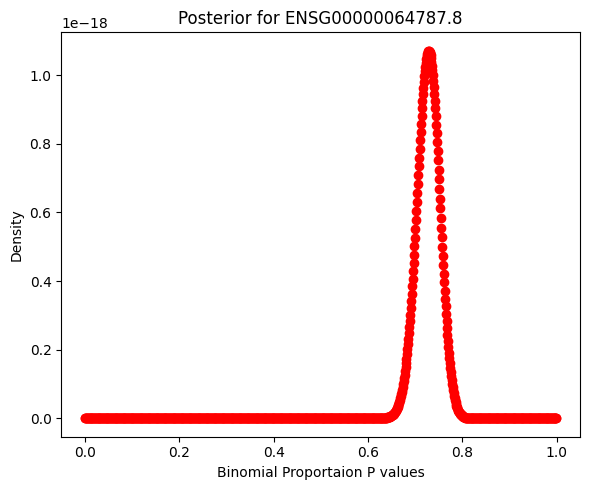

In [13]:
visualize_gene_data("/home/scarlett/github/RNAseq-analysis/run_quickBeast/test_data/ENSG00000064787.dist")

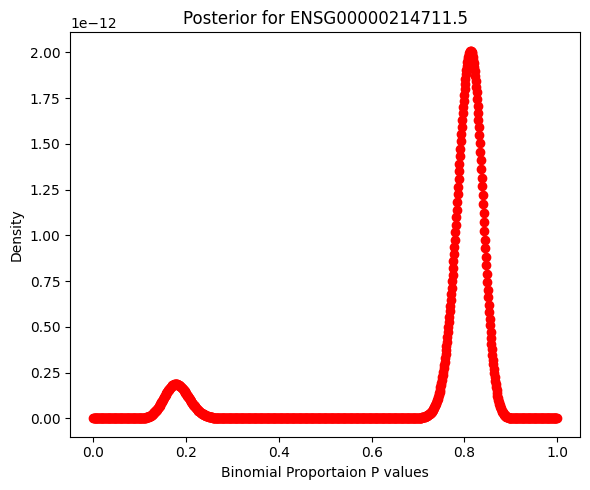

In [16]:
visualize_gene_data("/home/scarlett/github/RNAseq-analysis/run_quickBeast/test_data/ENSG00000214711.dist")

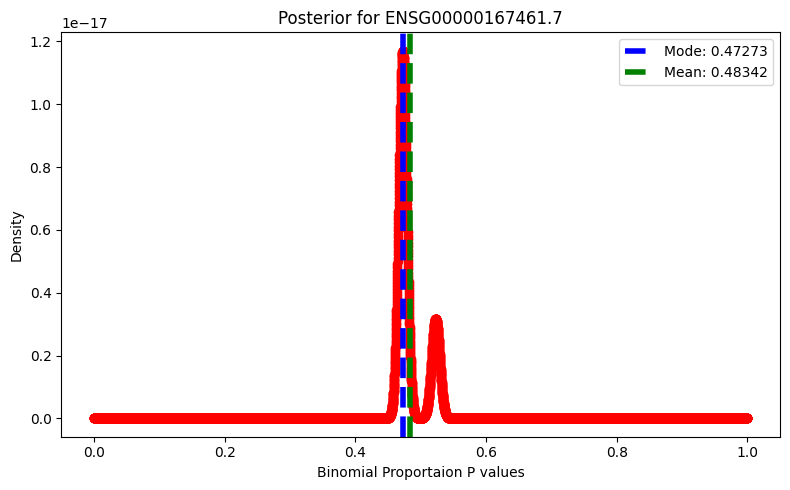

In [15]:
visualize_gene_data("/home/scarlett/github/QuickBEAST/out.dist",mean=0.483417868614,mode=0.472730815411)

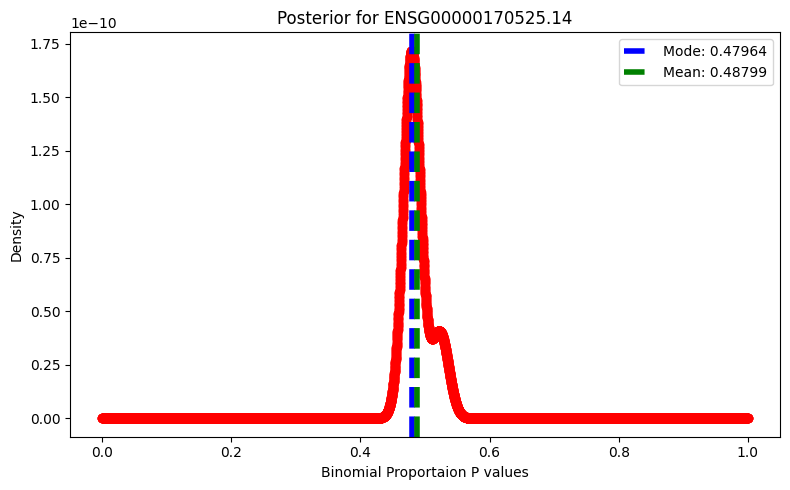

In [13]:
visualize_gene_data("/home/scarlett/github/QuickBEAST/out.dist",mean=0.487993925810,mode=0.479642808437)